In [18]:
%run PNe_fitting

Please type which Galaxy you want to analyse, use FCC000 format:  FCC167
Spaxel by Spaxel fit for the [OIII] doublet? (y/n)  n


3D fitter it is.......


Do you want to fit the detected sources in 3D + PSF analysis? (y/n) n


This is the end of PNe analysis script. Goodbye


<Figure size 432x288 with 0 Axes>

In [ ]:
%whos
%who_ls


In [16]:
gal_name = "FCC193"

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats
from ppxf_gal_L import ppxf_L_tot
from astroquery.vizier import Vizier

%config InlineBackend.figure_format = 'retina'

In [18]:
# functions
# Open Fits file and assign to raw_data

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219" or gal_name =="FCC193" or gal_name =="FCC083":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
elif gal_name == "FCC161":
    y_data, x_data = 451, 736
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), str(curr)+"/"+ str(total), end='')

# Load in data and plot FOV

In [19]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

In [20]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:136: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:137: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:141: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference


In [21]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

#D = galaxy_data["Distance"]

z = galaxy_data["z"]

gal_mask = galaxy_data["gal_mask"]
gal_vel = galaxy_data["velocity"]
star_mask = galaxy_data["star_mask"]

In [22]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.0001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))
    
        def gaussian(x, amplitude, mean, stddev, bkg, grad):
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/(len(wavelength)*n_pixels**2 - PNe_minimizer.nfree))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
    
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [ ]:
print("Running fitter")
if gal_name == "FCC219":
    gen_params(wave=5007*(1+z)-3, FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
else:
    gen_params(wave=5007*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict)
    
run_minimiser(PNe_multi_params)

Running fitter
 ####------------------------------------ [ 10.12%] 17/168

In [ ]:
moff_params_for_gandalf = np.array([moff_A[:,0], galaxy_data["FWHM"], galaxy_data["beta"], list_of_x, list_of_y])
np.save("exported_data/"+gal_name+"/fitted_moffat_params", moff_params_for_gandalf)

In [ ]:
def Moffat(Moff_A, FWHM, beta, x_0, y_0):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
    Moff = Moff_A * (1 + rr_gg)**(-beta)
    
    return Moff/np.sum(Moff)

list_of_params = np.load("exported_data/"+gal_name+"/fitted_moffat_params.npy")
list_of_Moff = [Moffat(list_of_params[0][n],list_of_params[1],list_of_params[2],list_of_params[3][n],list_of_params[4][n]) for n in range(len(x_PNe))]




## The Great Filter

In [ ]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3., "Filter"] = "N"
# reduced Chi sqr cut
redchi_med = np.median(PNe_df["redchi"].values)
redchi_std = robust_sigma(PNe_df["redchi"].values)
lower_redchi = redchi_med - 3*redchi_std
upper_redchi = redchi_med + 3*redchi_std
PNe_df.loc[(PNe_df["redchi"]>=upper_redchi) & (PNe_df["redchi"]<=lower_redchi), "Filter"] = "N"


## FCC167
if gal_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==30, "Filter"] = "N" # Over luminous [OIII] source
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # SNR maybe, extended source with dual peaked [OIII] 5007
    #PNe_df.loc[PNe_df["PNe number"]==126, "Filter"] = "N" # SNR maybe, extended source
## FCC219
#elif gal_name == "FCC219":
    # Put filtered out objects here
elif gal_name == "FCC193":
    PNe_df.loc[PNe_df["PNe number"]==137, "Filter"] = "N" 
    PNe_df.loc[PNe_df["PNe number"]==59, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==136, "Filter"] = "N"
    PNe_df.loc[PNe_df["PNe number"]==122, "Filter"] = "N"
#elif gal_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
elif gal_name == "FCC249":
    PNe_df.loc[PNe_df["PNe number"]==2, "Filter"] = "N" 

    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

# Error analysis

In [ ]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(moff_A[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]

        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        mean_m5007[n], m5007_err[n] = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [45]:
PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(3, "m 5007")

PNe number Ra (J2000) Dec (J2000)    V (km/s)     m 5007    M 5007  \
2            2        NaN         NaN -167.988154  27.061526 -4.510000   
1            1        NaN         NaN -254.523314  27.204660 -4.366866   
18          18        NaN         NaN -476.906216  27.434595 -4.136930   

     [OIII] Flux M 5007 error       A/rN rad D    redchi Filter          Chi2  \
2   4.779579e-17          NaN  13.087847   NaN  1.007858      Y  15266.031020   
1   4.189247e-17          NaN   8.189973   NaN  0.999265      Y  15135.868760   
18  3.389704e-17          NaN   8.512629   NaN  1.033749      Y  15658.189577   

      Flux error  m 5007 error  F[OIII] err percent  
2   1.367790e-18      0.031061             2.861737  
1   1.344443e-18      0.034798             3.209271  
18  1.082500e-18      0.034729             3.193493

In [ ]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]
print(p_n)

Dist_est = 10.**(((m + 4.51) -25.) / 5.)
dist_diff_p = 10.**(((m+m_err + 4.51) -25.) / 5.)
dist_diff_m = 10.**(((m-m_err + 4.51) -25.) / 5.)
print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "Mpc, +{0:.4f} -{1:.4f}".format(dist_diff_p-Dist_est, Dist_est-dist_diff_m),"Mpc")

dM =  5. * np.log10(Dist_est) + 25.
dM_lower = 5. * np.log10(dist_diff_p) + 25.
dM_upper = 5. * np.log10(dist_diff_m) + 25.

print("dM = {:.4f}".format(dM),"+/- {:.4f}".format(dM-dM_upper))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

In [ ]:
### FCC167

### FCC219

### FCC193
Distance Estimate from PNLF:  19.152 Mpc, +0.2253 -0.2226 Mpc
dM = 31.4111 +/- 0.0254

### FCC161
Distance Estimate from PNLF:  17.550 Mpc, +0.4189 -0.4092 Mpc
dM = 31.2214 +/- 0.0512
or
Distance Estimate from PNLF:  19.783 Mpc, +0.2522 -0.2491 Mpc
dM = 31.4815 +/- 0.0275

### FCC147
Distance Estimate from PNLF:  20.891 Mpc, +0.4028 -0.3951 Mpc
dM = 31.5998 +/- 0.0415

Distance Estimate from PNLF:  19.026 Mpc, +0.3621 -0.3554 Mpc
dM = 31.3967 +/- 0.0409

### FCC083
Distance Estimate from PNLF:  17.875 Mpc, +0.2058 -0.2035 Mpc
dM = 31.2612 +/- 0.0249

### FCC255
Distance Estimate from PNLF:  20.609 Mpc, +0.2875 -0.2835 Mpc
dM = 31.5703 +/- 0.0301
  OR
Distance Estimate from PNLF:  21.661 Mpc, +0.2548 -0.2519 Mpc
dM = 31.6784 +/- 0.0254

### FCC249
Distance Estimate from PNLF:  22.961 Mpc, +0.3282 -0.3236 Mpc
dM = 31.8049 +/- 0.0308

### FCC310
Distance Estimate from PNLF:  20.929 Mpc, +0.4416 -0.4325 Mpc
dM = 31.6037 +/- 0.0453

### FCC277
Distance Estimate from PNLF:  21.402 Mpc, +0.4390 -0.4301 Mpc
dM = 31.6522 +/- 0.0441

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

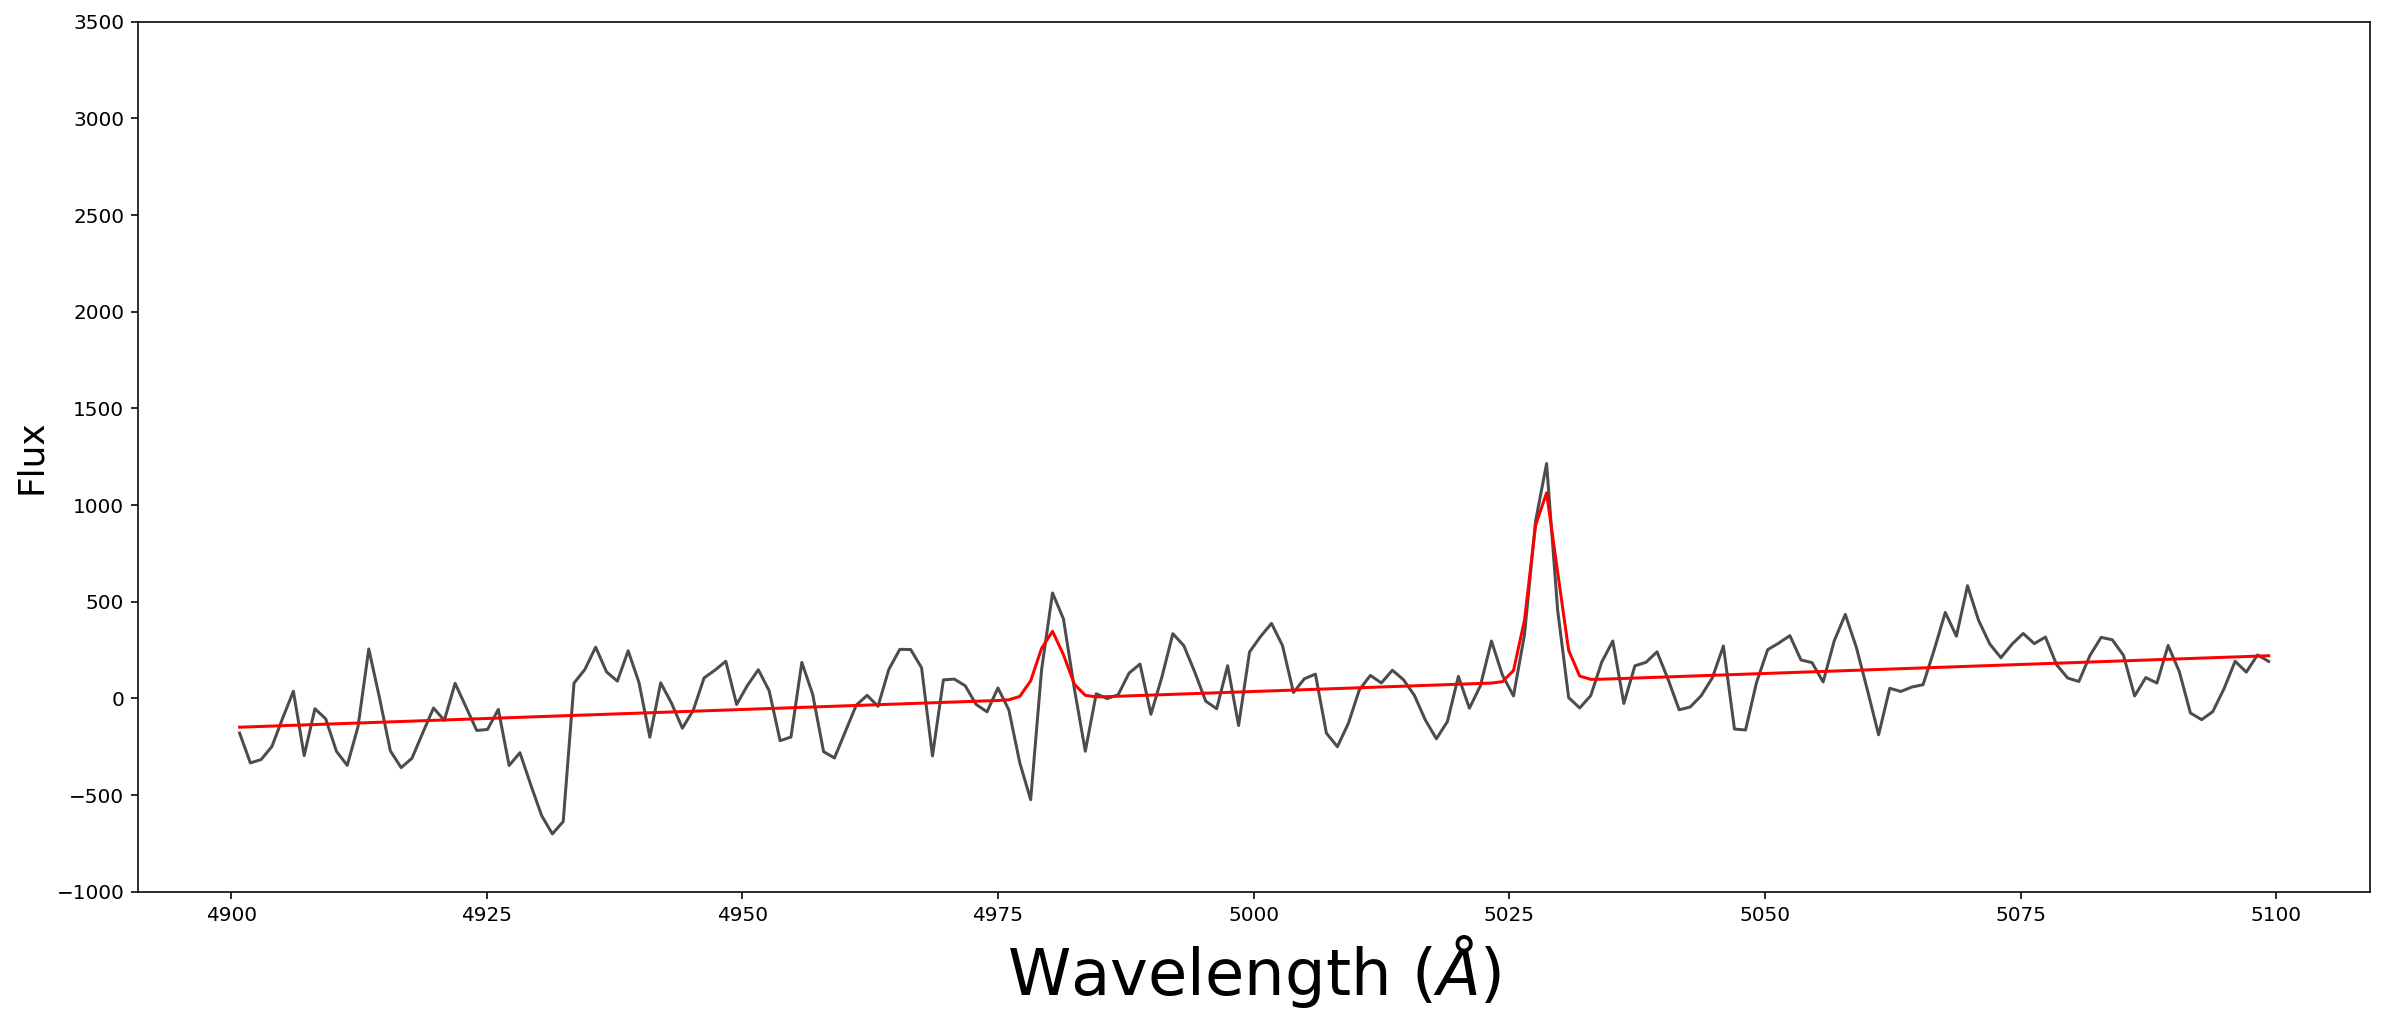

In [26]:
p = 28
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k") # *moff_weight[:,None]

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)

## Spaxel by spaxel with individual fits

In [ ]:
p = 27
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

fig = plt.figure(figsize=(80,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", alpha=1.0)
    ax1.tick_params(labelsize = 14, pad=8)
    ax1.set_xlim(4900,5100)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg s^{-1}$ $cm^{-2}$ $\AA^{-1}$ $arcsec^{-2}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30)

#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_"+"{}".format(p)+"_spaxel_by_spaxel_fit_view.pdf", bbox_inches='tight')

## [OIII] / Ha   (+[NII])

In [18]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

Text(0.5, 0, '$M_{5007}$')

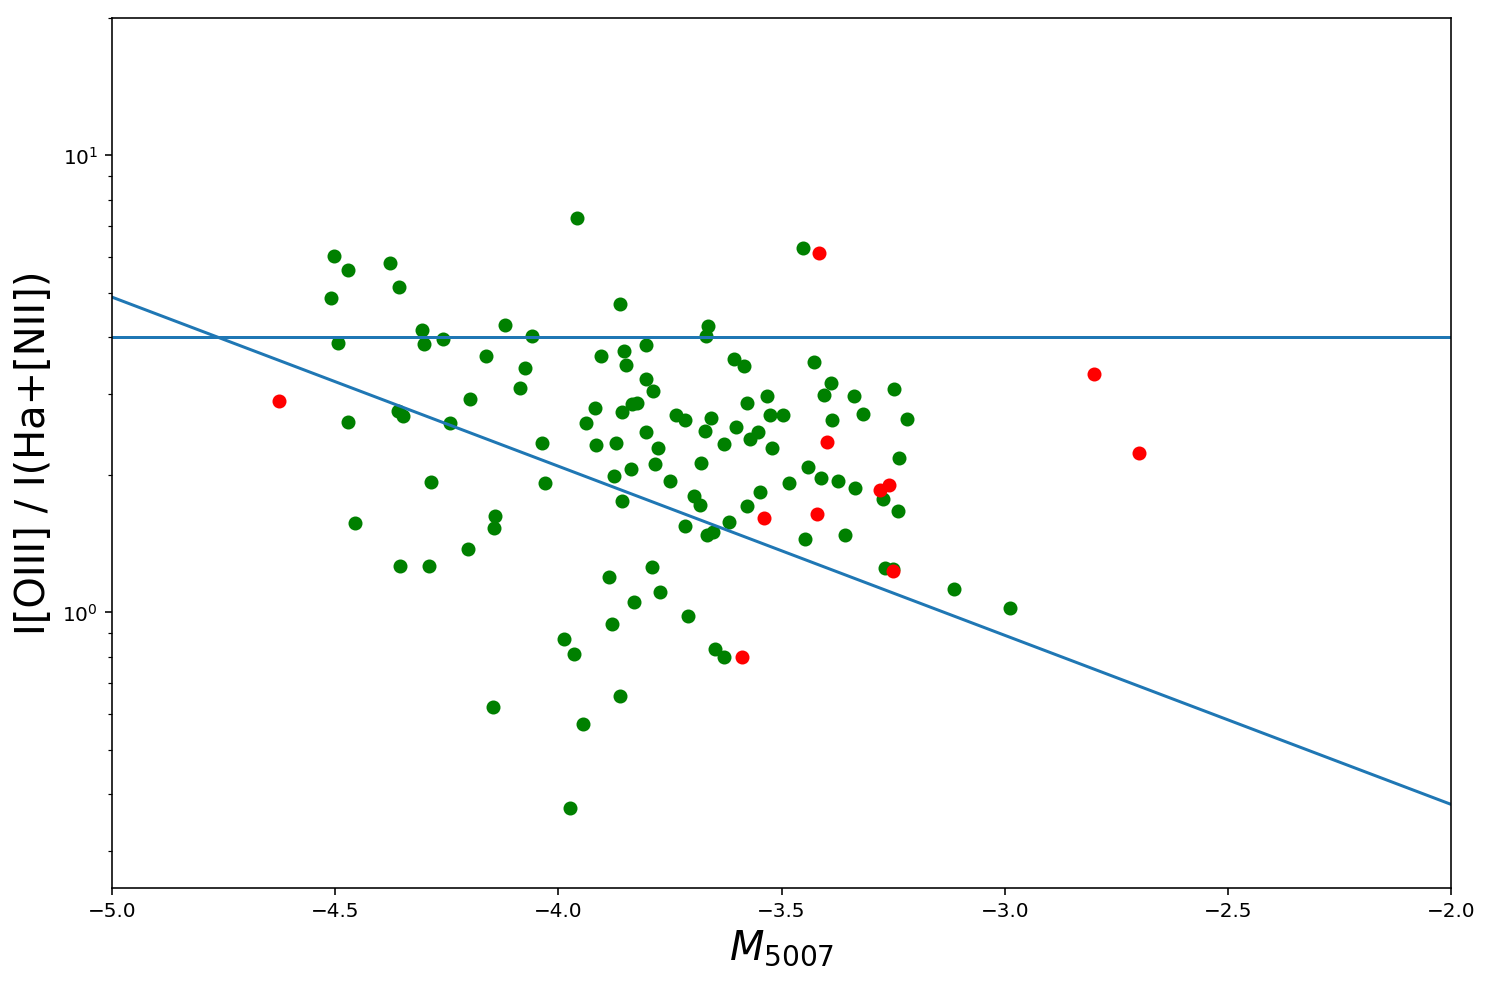

In [15]:
em_ratios = np.load("exported_data/FCC167/gandalf/emission_ratios.npy")
OIII_by_Ha, OIII_by_Ha_plus_NII, NII_by_Ha, OIII_by_SII = em_ratios

PNe_df["OIII/Ha"] = OIII_by_Ha
PNe_df["OIII/Ha+NII"] = OIII_by_Ha_plus_NII
PNe_df["NII/Ha"] = NII_by_Ha
PNe_df["OIII/SII"] = OIII_by_SII

plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], OIII_by_Ha_plus_NII[y_idx], c="g")
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="N"], OIII_by_Ha_plus_NII[n_idx], c="r")

plt.axhline(4)
plt.ylim(0.25,20)
plt.xlim(-5,-2)
x = np.arange(-5, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("I[OIII] / I(Ha+[NII])", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

In [92]:
contamination = PNe_df.loc[PNe_df["OIII/Ha+NII"]<10**((-0.37 * PNe_df["M 5007"].values) - 1.16)].index.values
len(contamination)

32

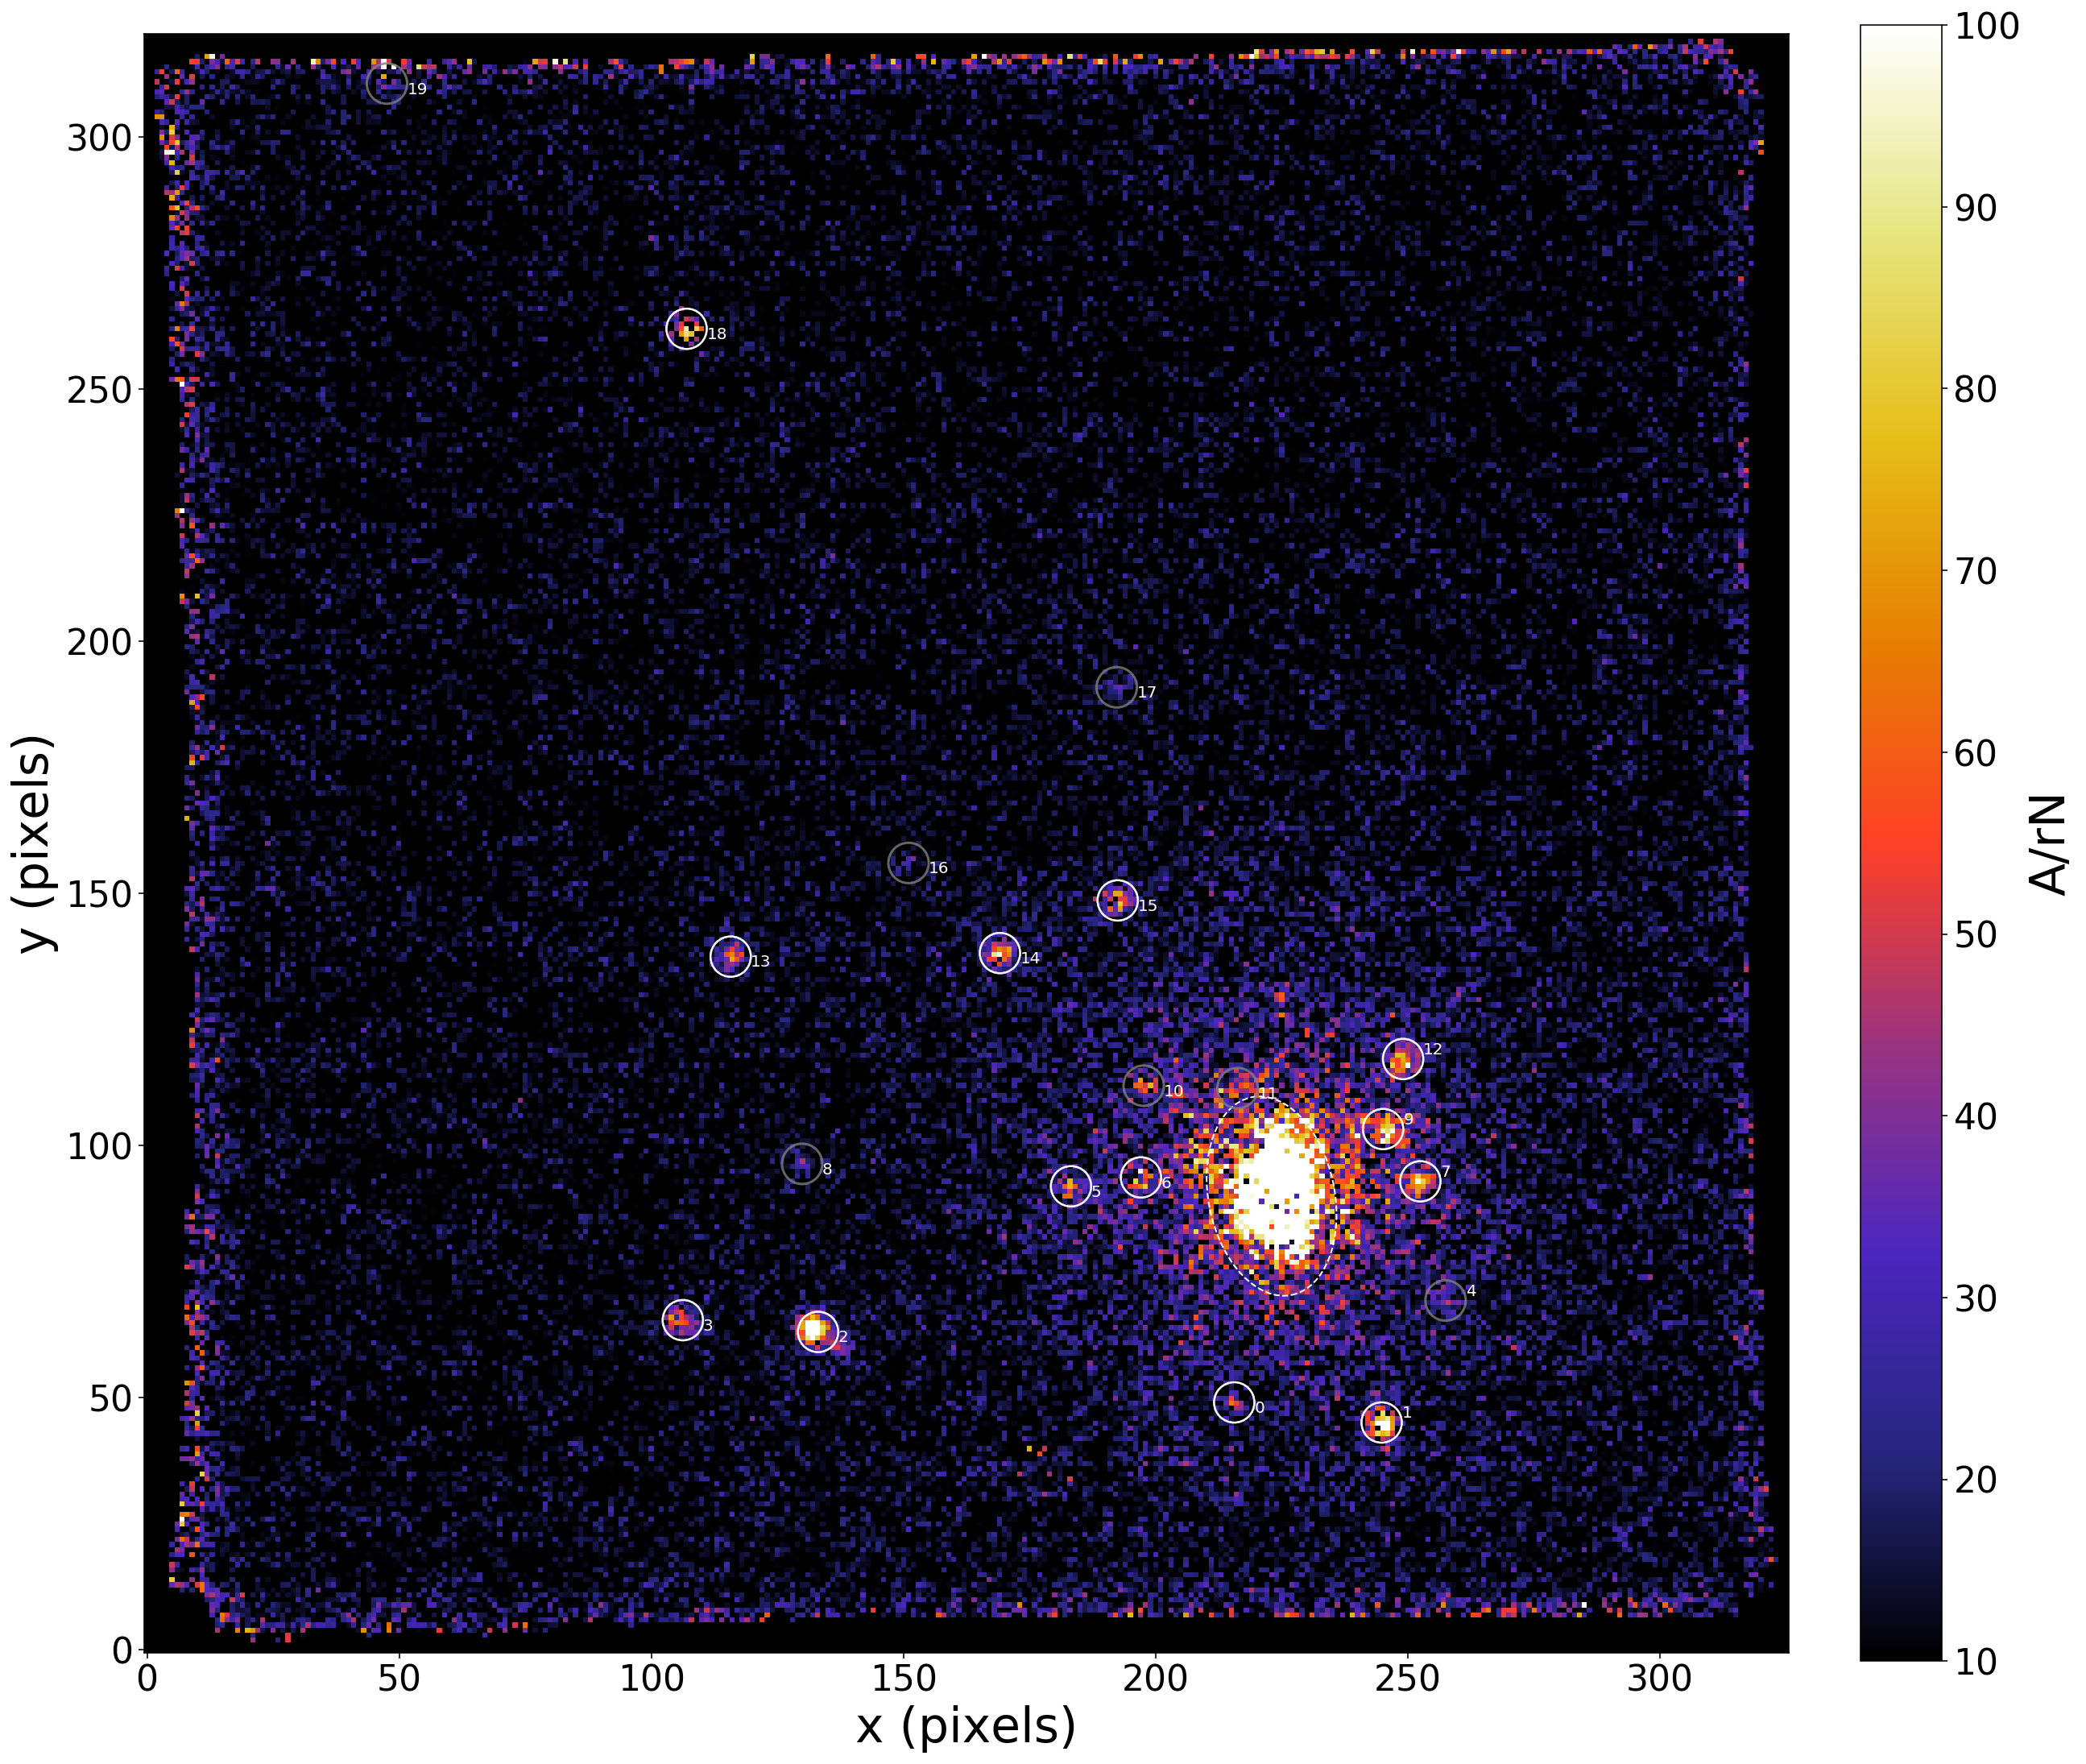

In [35]:
plt.figure(figsize=(20,20))
#plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=100)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask

if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif gal_name=="FCC161":
    plt.xlim(0,450)
elif gal_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif gal_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)
elif gal_name=="FCC310":
    plt.xlim(0,410)
    plt.ylim(100,)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white", ls="--")
ax.add_artist(elip_gal)

for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="white",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="grey",lw=1.5, fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+4, item[1]-2), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+4, item[1]+1), color="white", size=10)

        
# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    
#plt.axvline(190)
#plt.axhline(110)
#plt.savefig("Plots/"+gal_name+"/A_rN_circled.pdf", bbox_inches='tight')

# Scatter points for measured PNe velocity

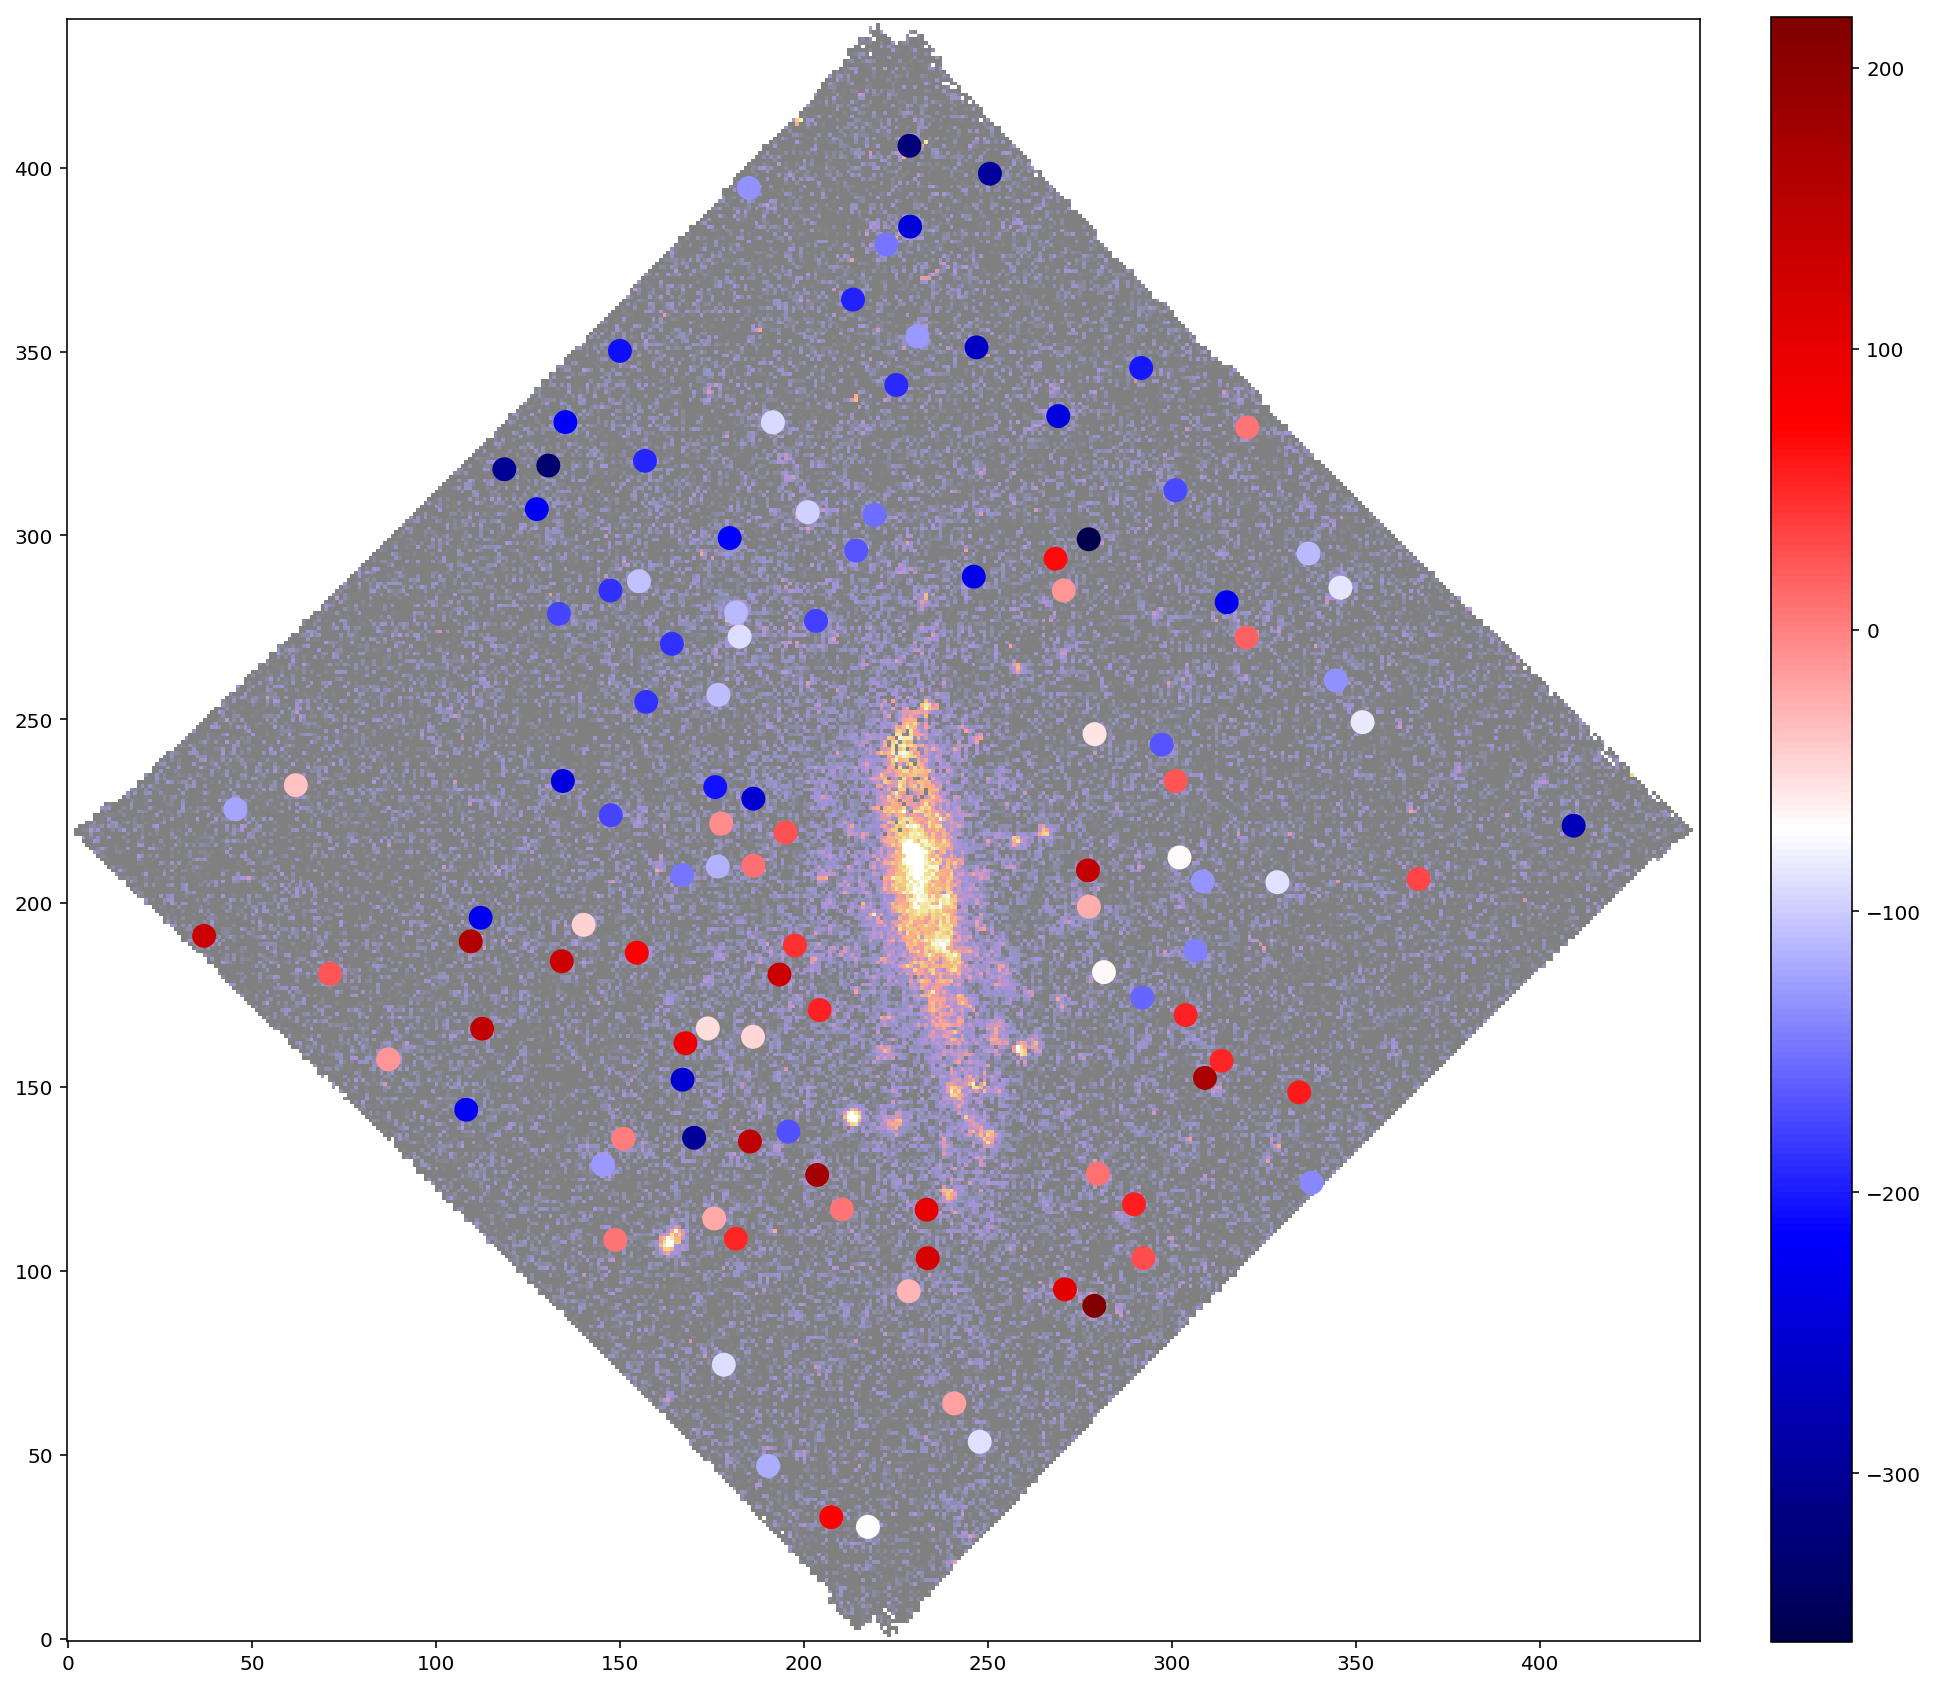

In [17]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if gal_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif gal_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

In [ ]:
plt.figure()
plt.plot()


def plot():
    plt.figure()
    plt.plot()
    input("Press enter when ready: ")
    plt.clf()
    
plot()
plt.plot()

In [101]:
## Velocity from files

hdulist_table = fits.open(gal_name+"_data/"+gal_name+"center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

hdulist_ppxf = fits.open(gal_name+"_data/"+gal_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.average(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
if gal_name == "FCC167":
    gal_x_c = 230
    gal_y_c = 212
elif gal_name == "FCC219":
    gal_x_c = 190
    gal_y_c = 110
elif gal_name == "FCC193":
    gal_x_c = 170
    gal_y_c = 405

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])


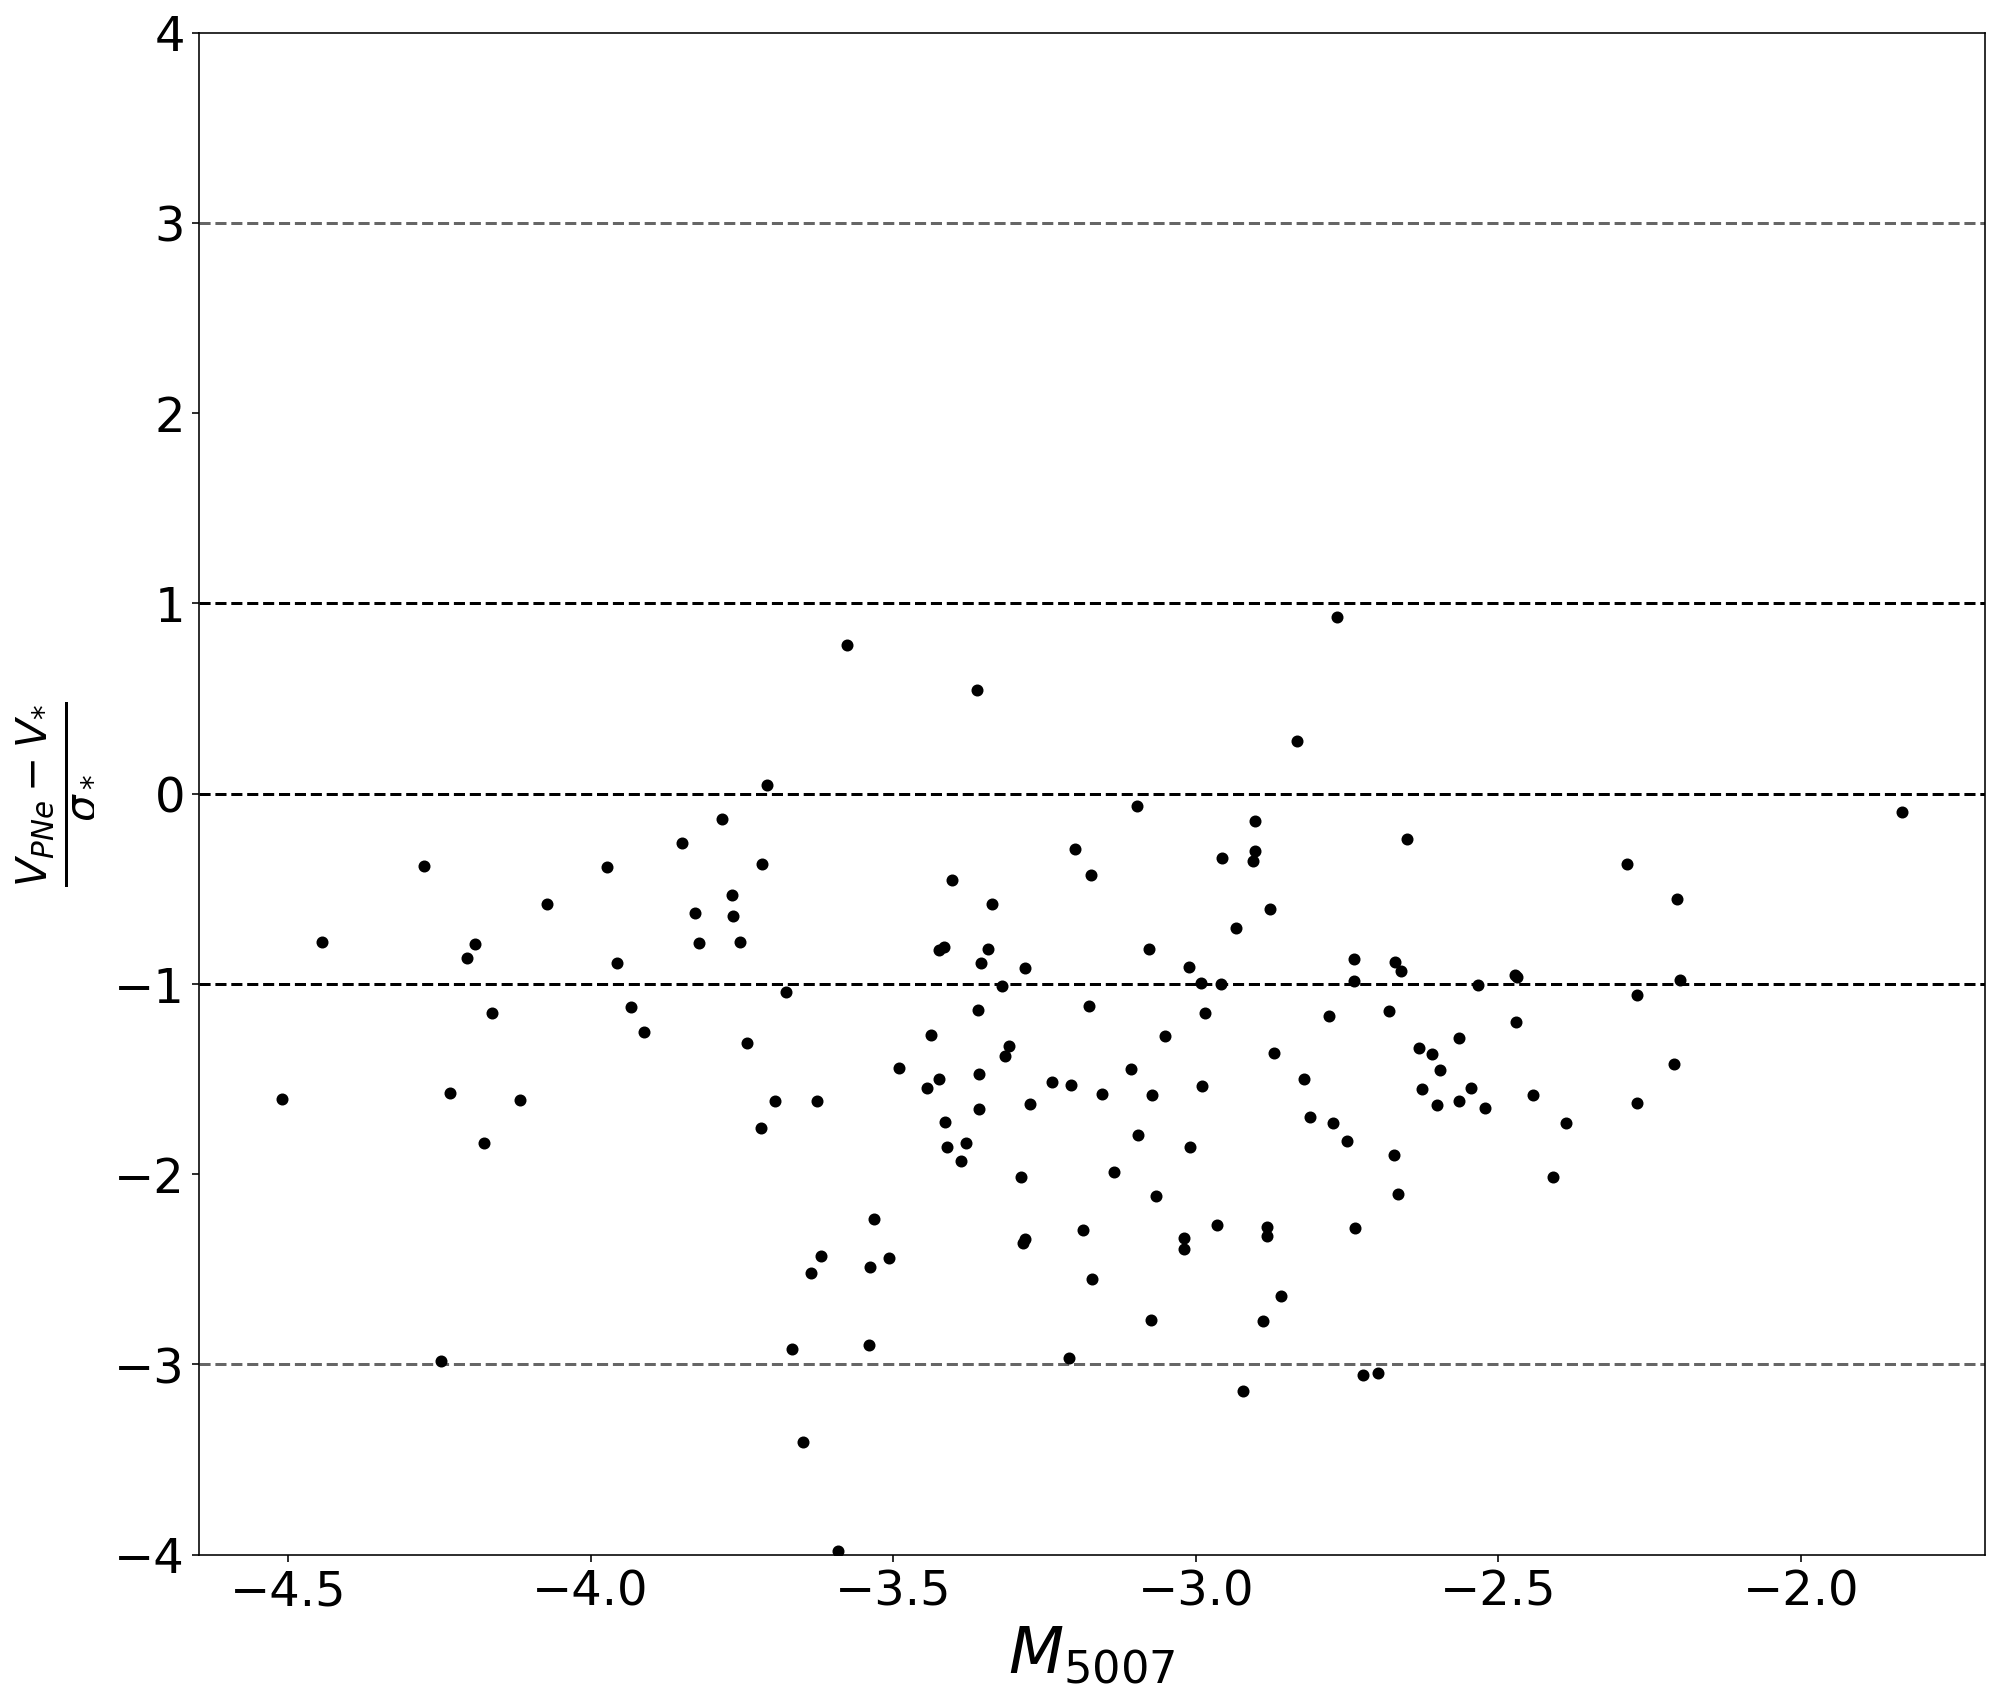

In [102]:
plt.figure(44, figsize=(16,14))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=32)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.ylim(-4,4)
plt.tick_params(labelsize = 24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_velocity_plot.pdf", bbox_inches='tight')

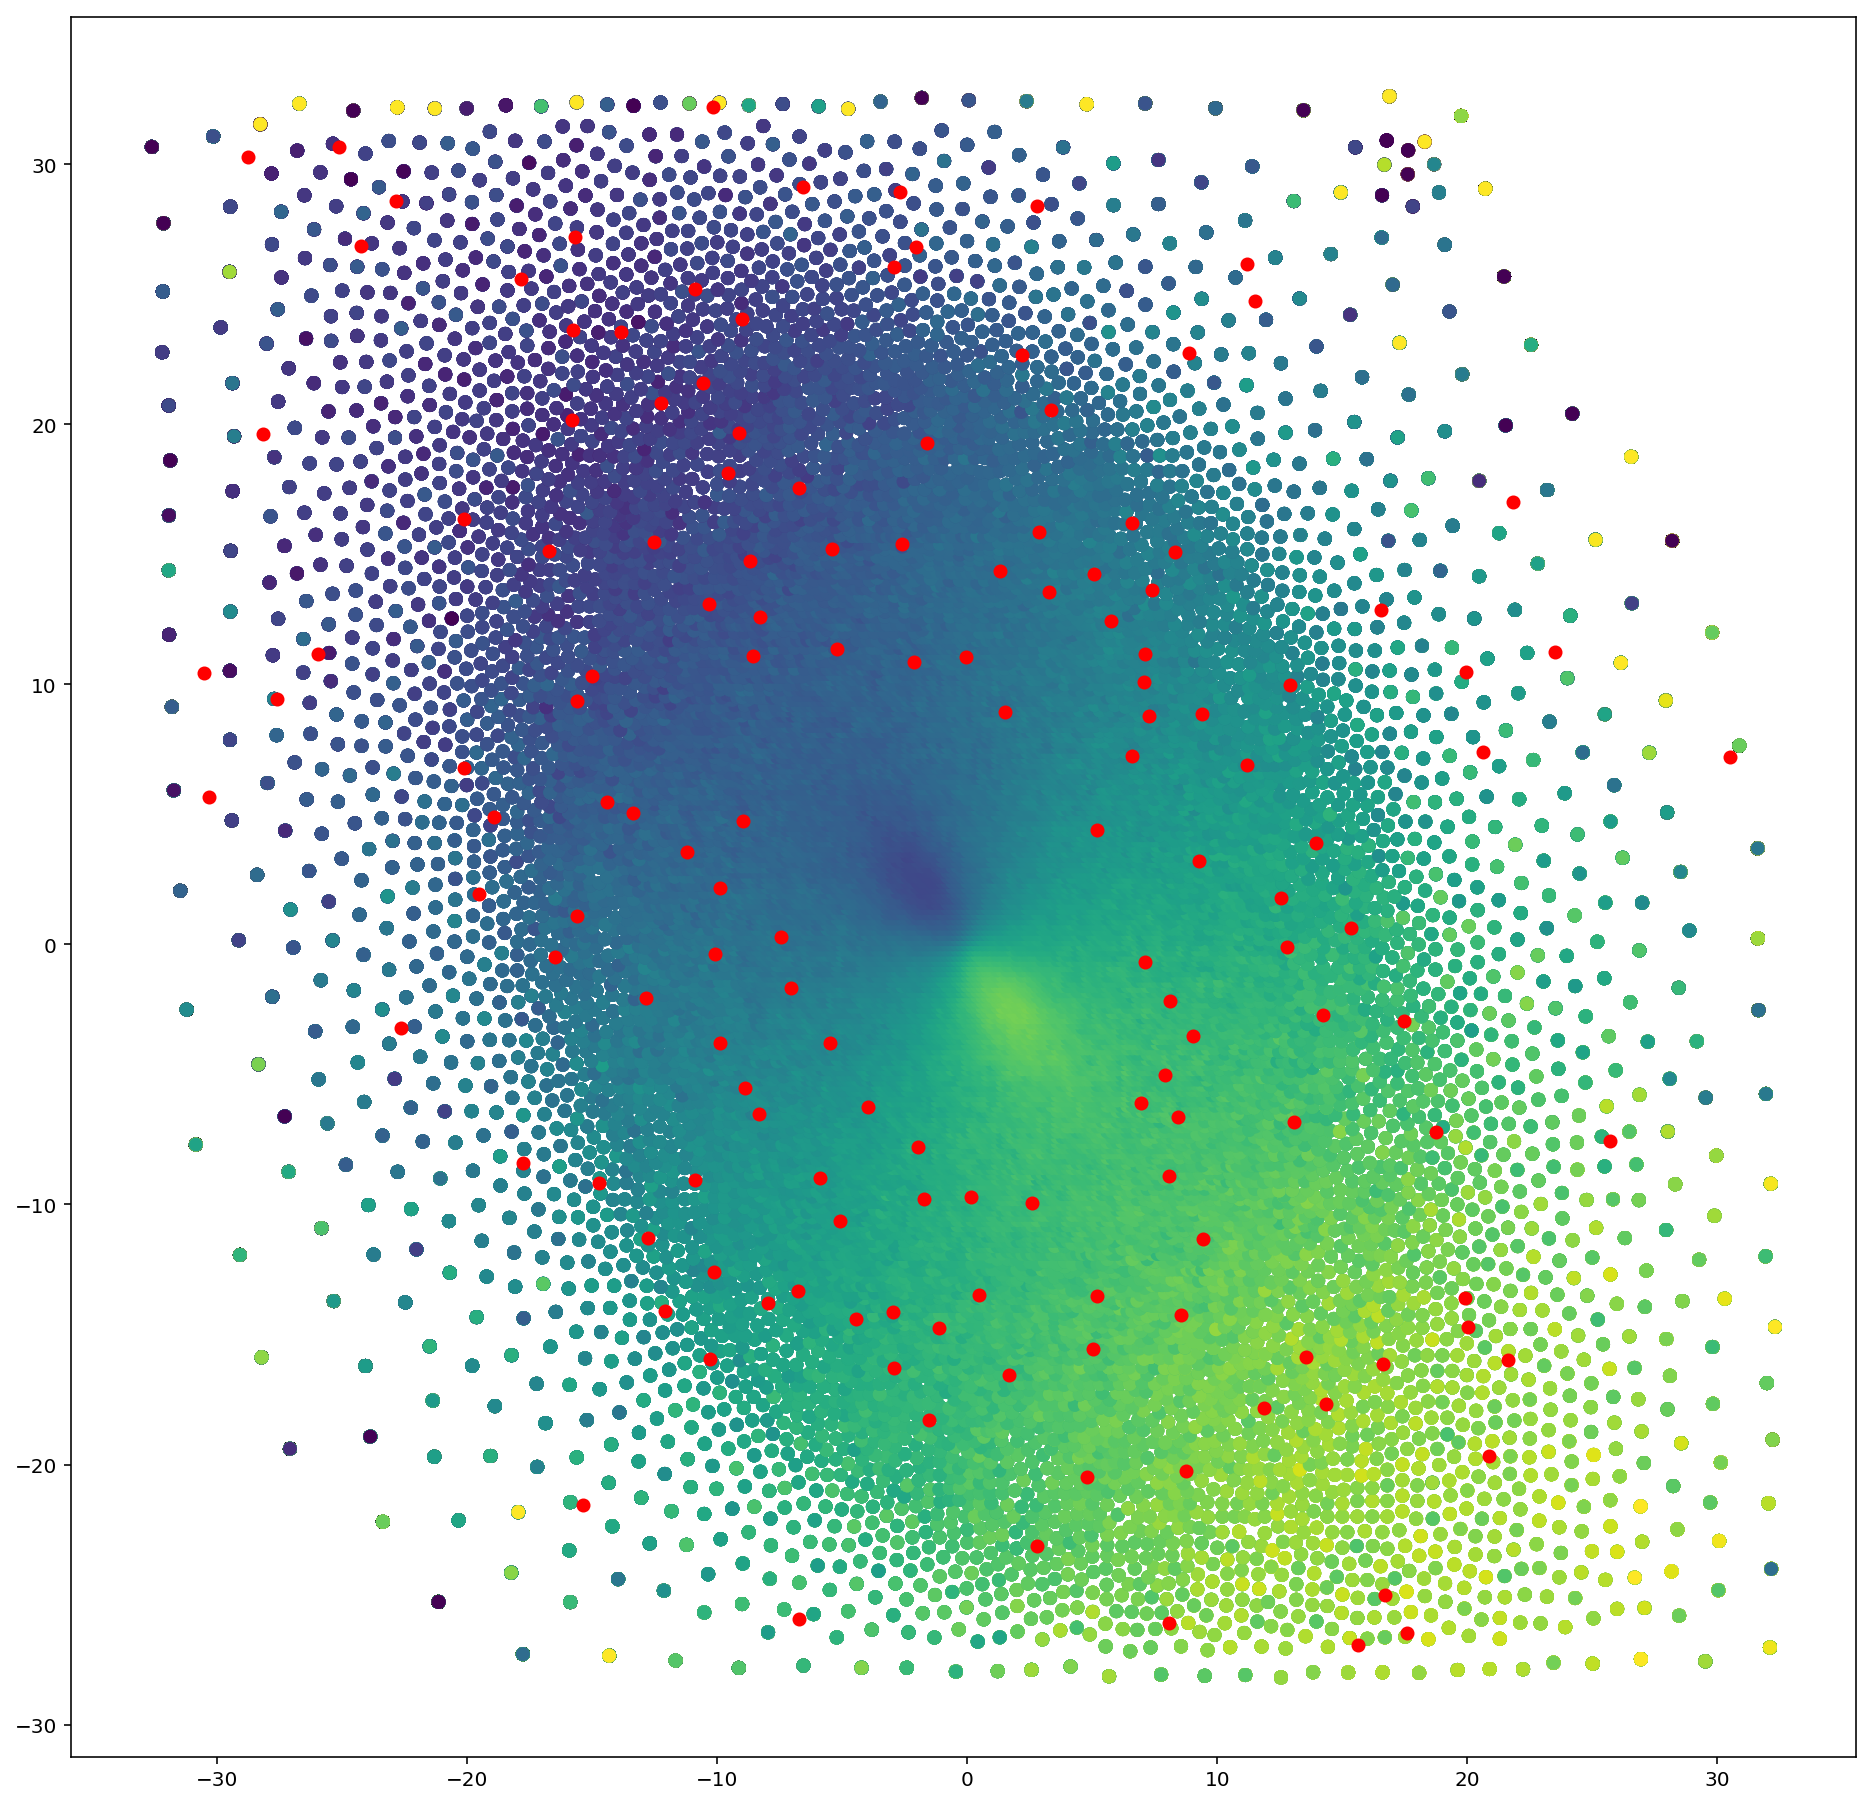

In [92]:
plt.figure(figsize=(16,16))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

# SEP - Source Detection

20


<Figure size 1440x1440 with 0 Axes>

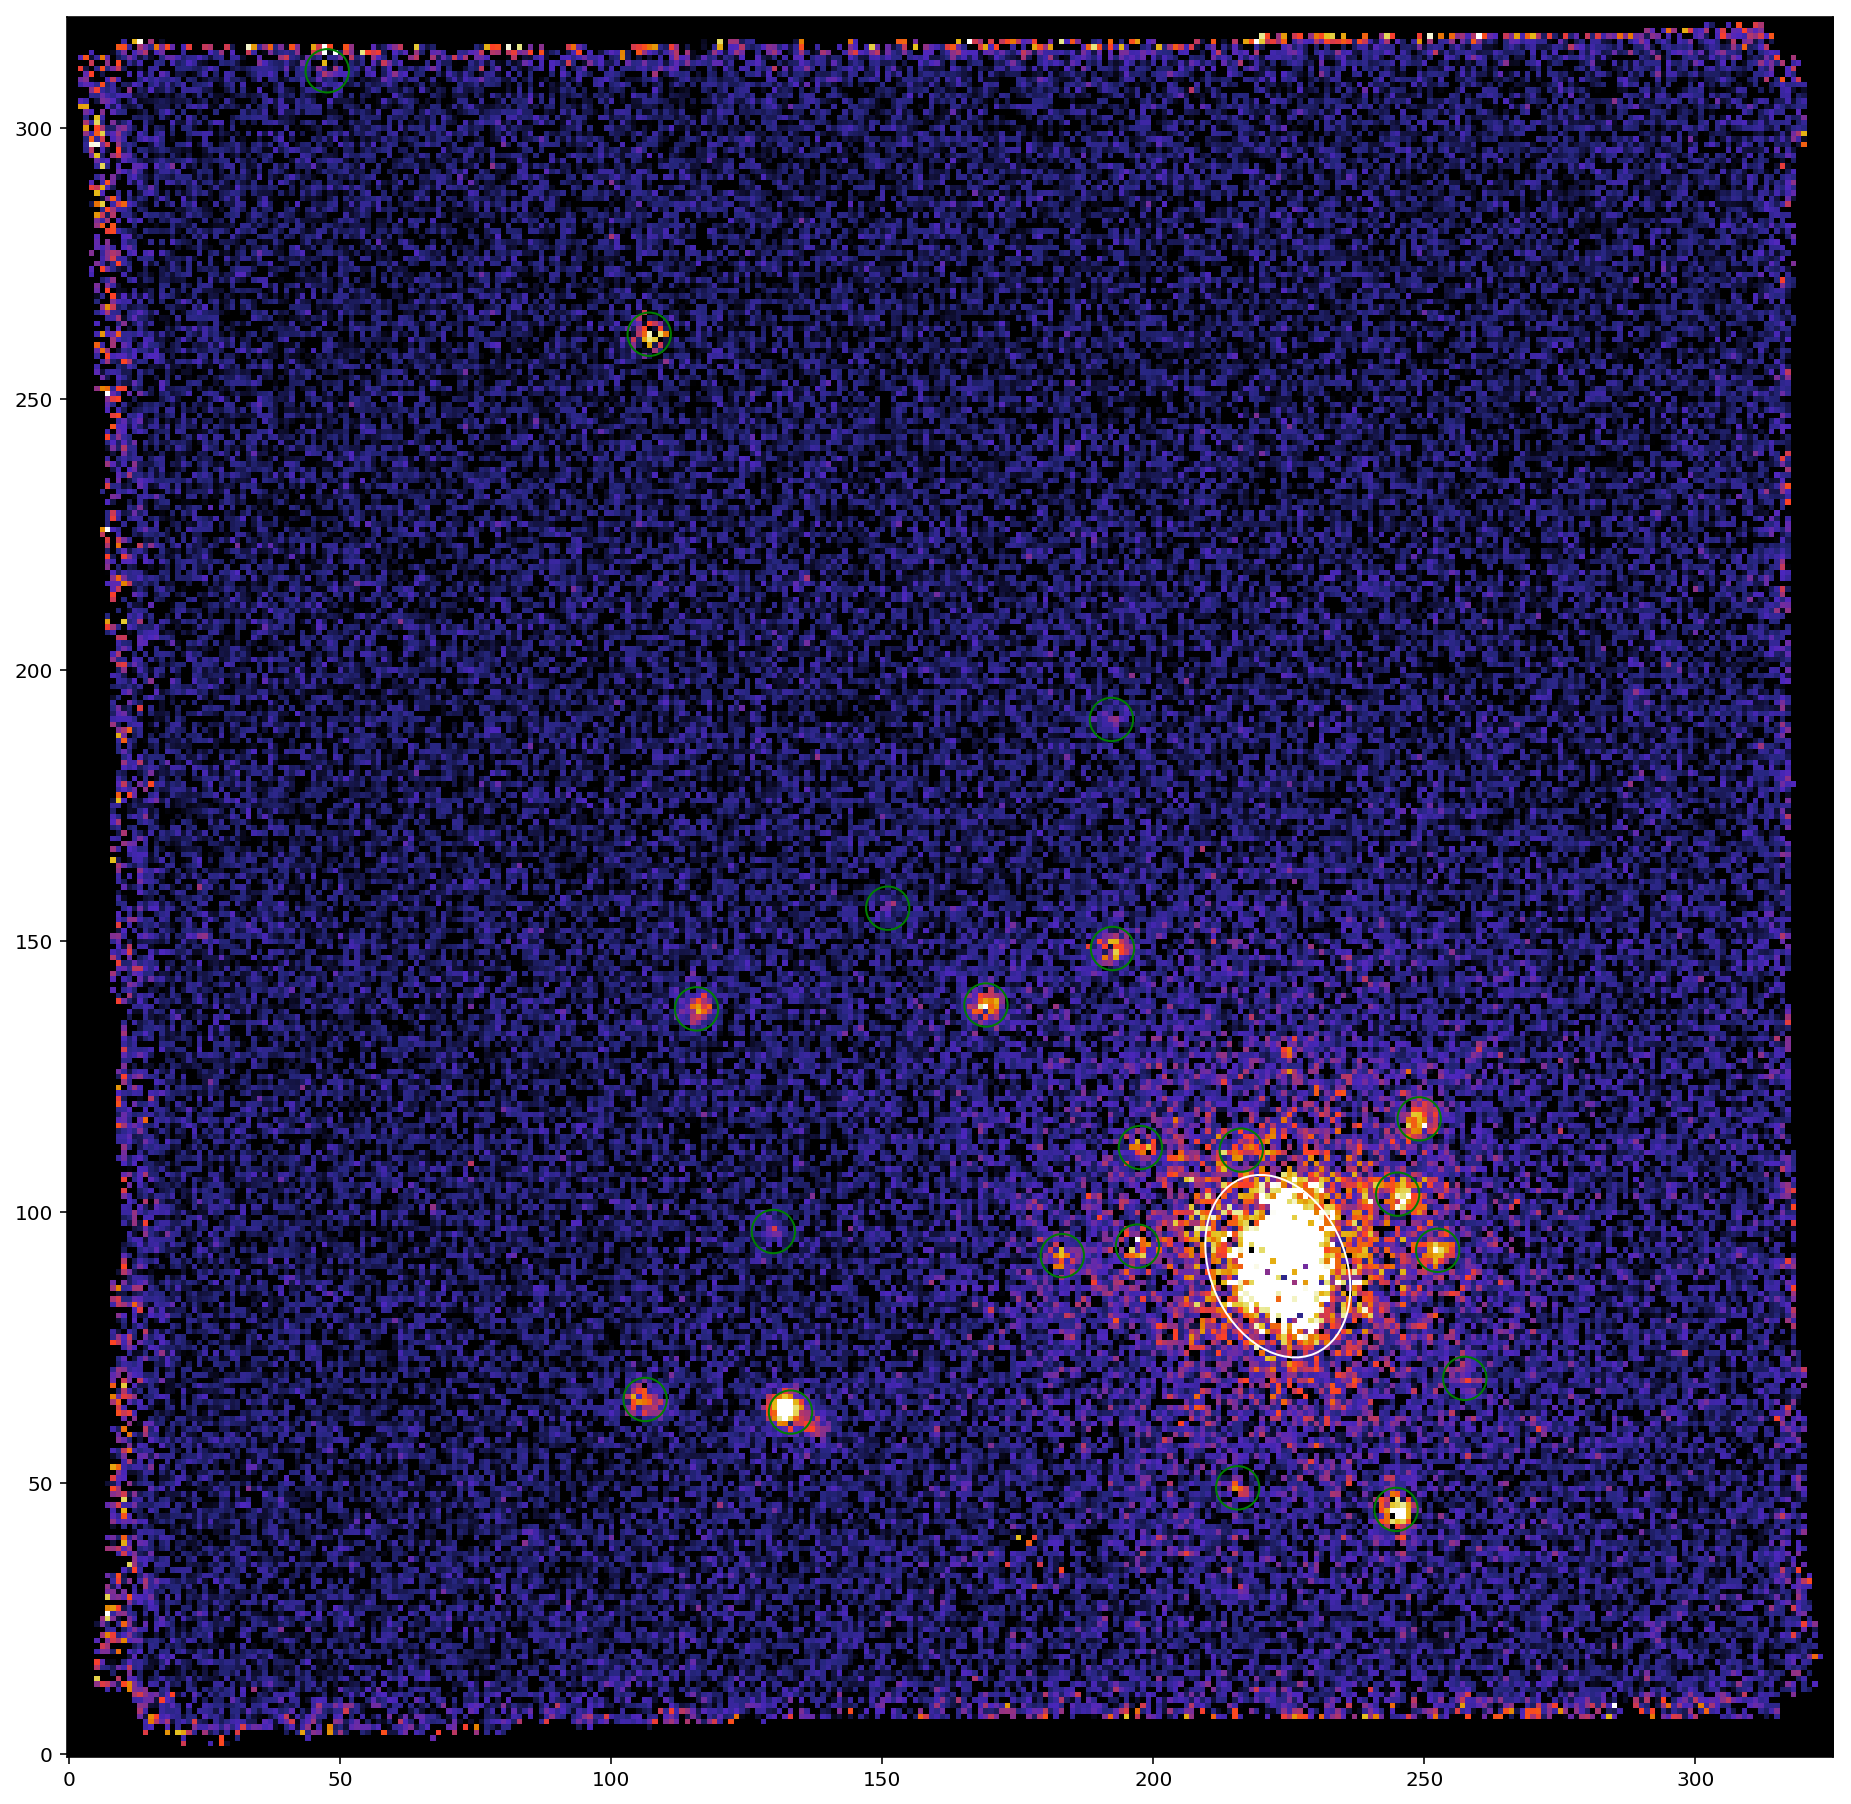

In [27]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = [223,90,35,25,0.4] #gal_mask

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, mask=elip_mask_gal)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
#plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

#plt.xlim(0,370)
#plt.ylim(0,370)

ax = plt.gca()

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

In [ ]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, "exported_data/"+gal_name+"/SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, "exported_data/"+gal_name+"/SEP_filtered_data_Table.dat", overwrite=True)

# PSF determination

[2]
FWHM:  4.567563002066841 +/- 0.14251282496922577 (3.12%)
Beta:  1.4001416734784453 +/- 0.17246315914047827 (12.32%)
LSF:  3.1610506403324212 +/- 0.050526432663154076 (1.60%)




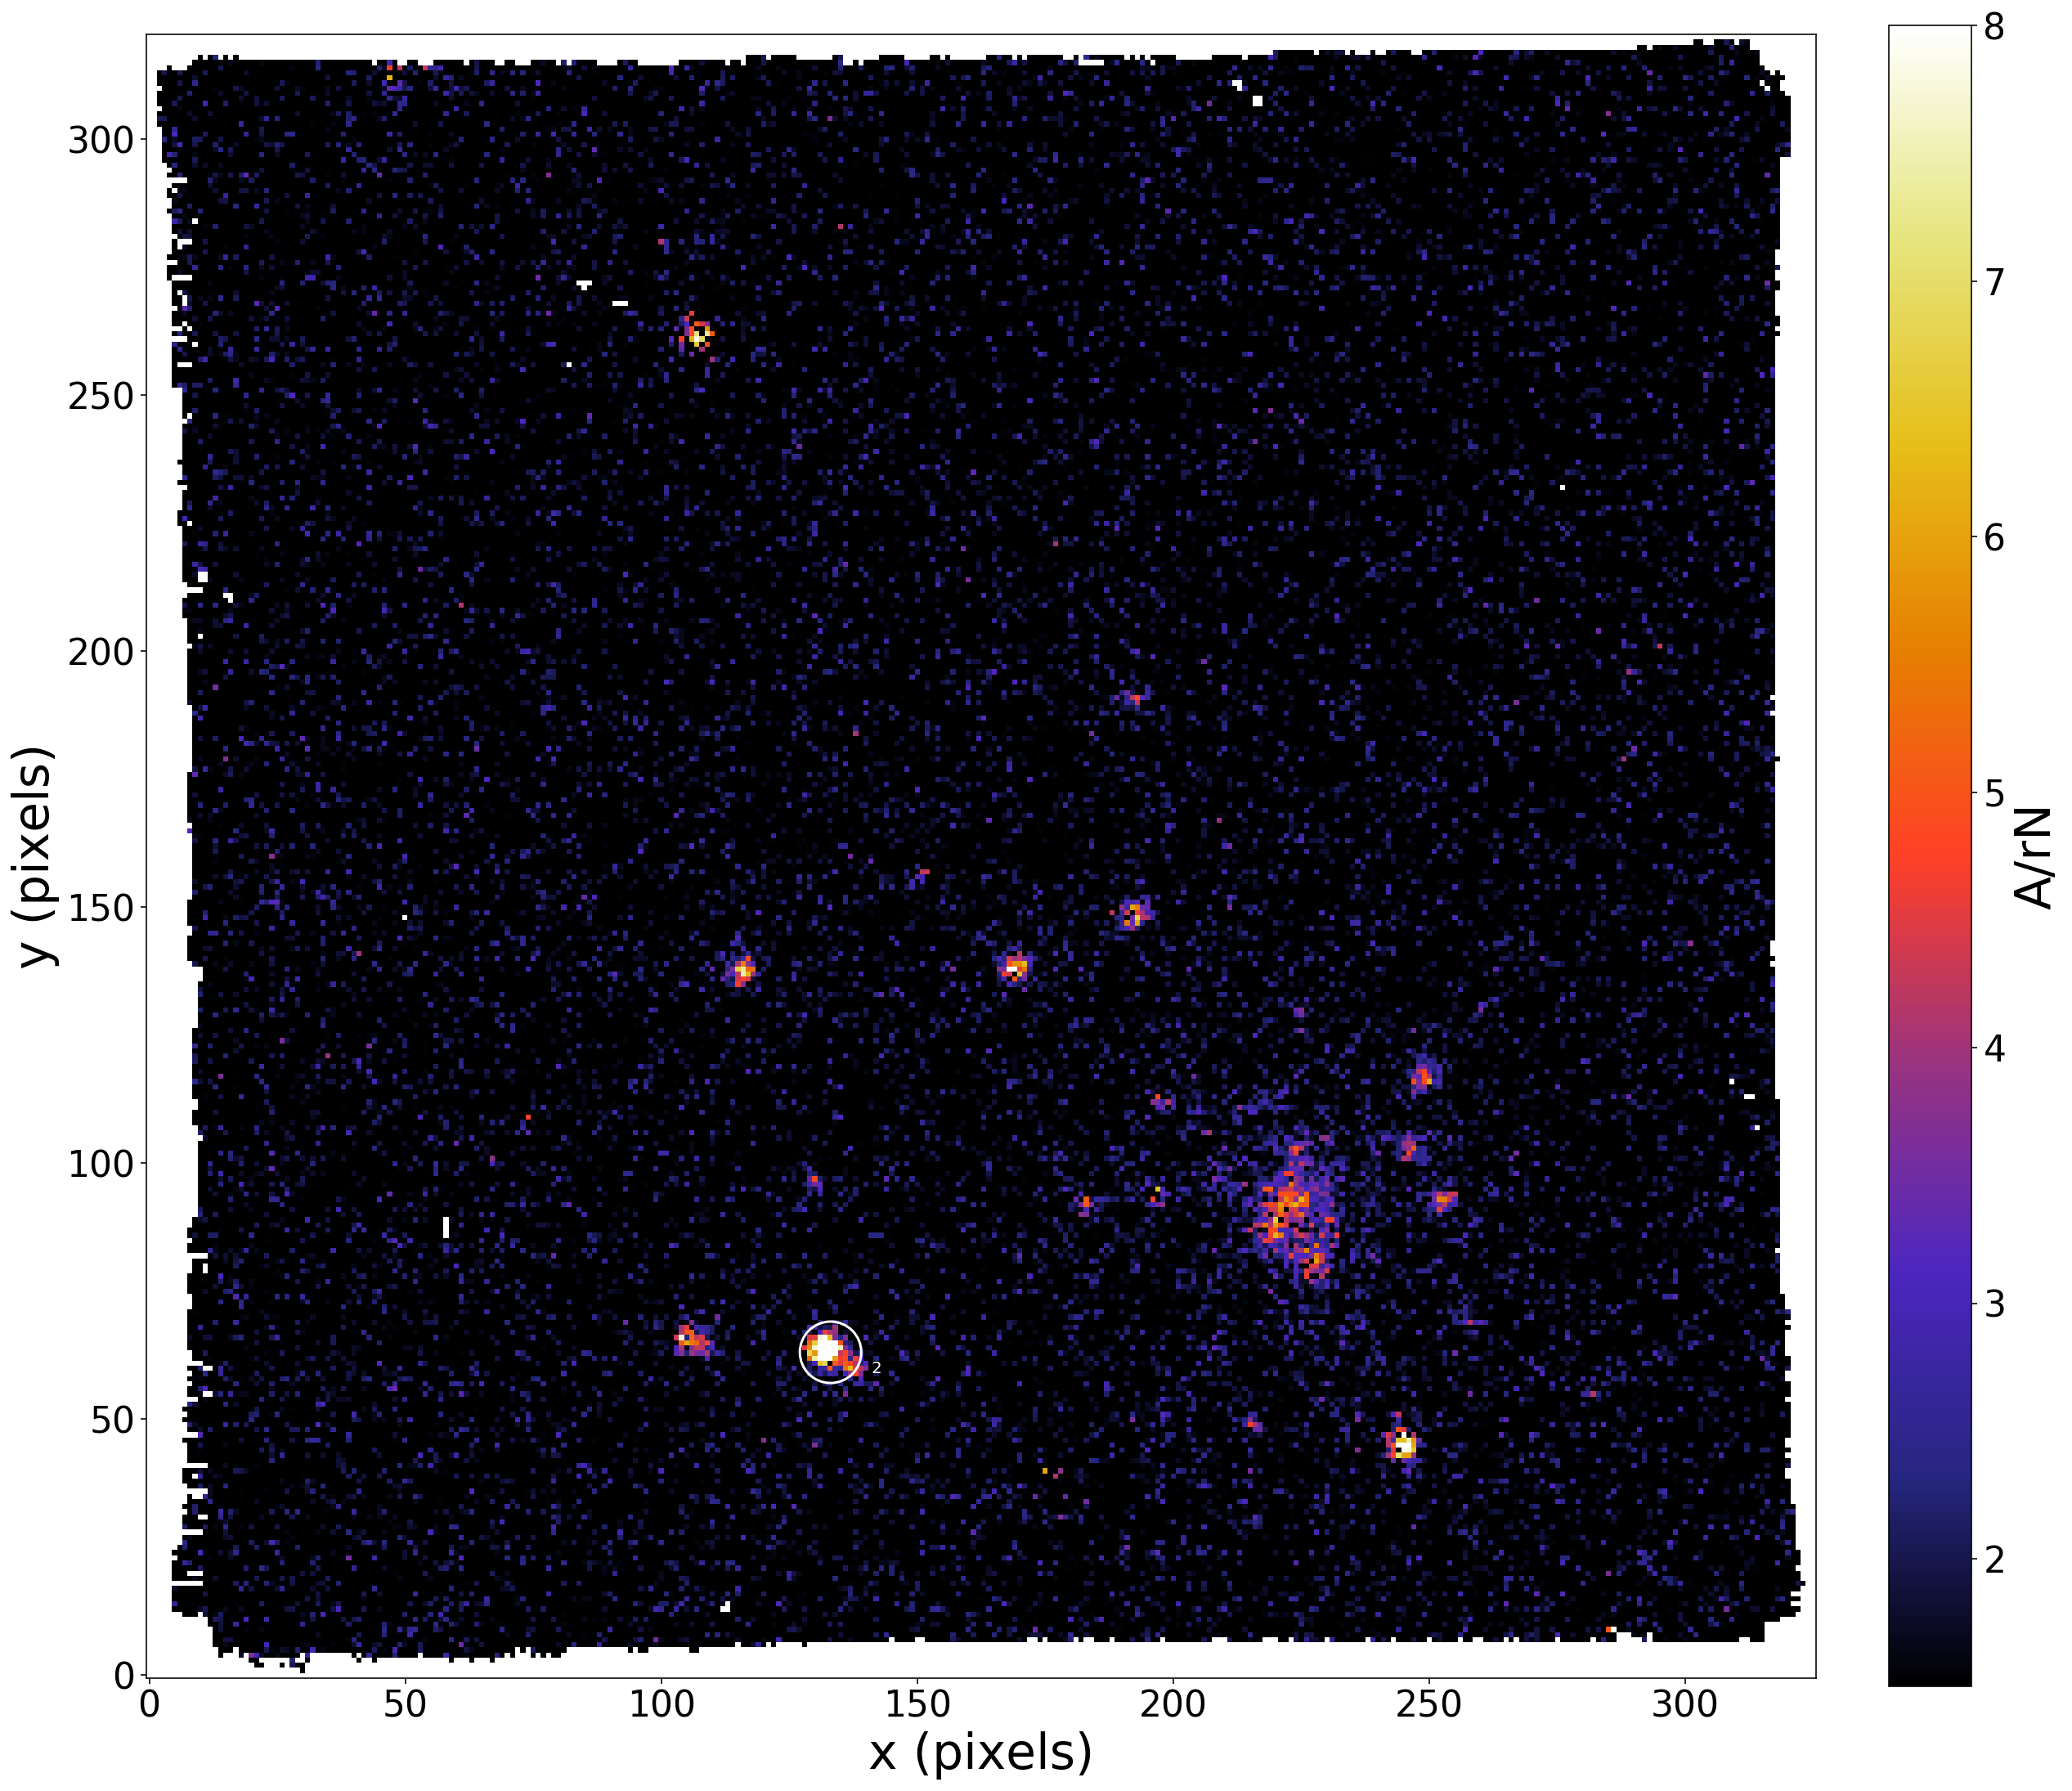

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 15147
    # variables        = 7
    chi-square         = 175384.348
    reduced chi-square = 11.5841710
    Akaike info crit   = 37111.6893
    Bayesian info crit = 37165.0682
[[Variables]]
    moffat_amp_000:  164.858566 +/- 4.40212947 (2.67%) (init = 200)
    x_000:           4.62748813 +/- 0.03975707 (0.86%) (init = 4.5)
    y_000:           3.09346262 +/- 0.03973090 (1.28%) (init = 4.5)
    wave_000:        5031.74642 +/- 0.02145803 (0.00%) (init = 5034.794)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    FWHM:            4.56756300 +/- 0.14251282 (3.12%) (init = 4)
    beta:            1.40014167 +/- 0.17246316 (12.32%) (init = 2.5)
    LSF:             3.16105064 +/- 0.05052643 (1.60%) (init = 2.81)
None


In [48]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if gal_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 122].nlargest(5, "A/rN").index.values
elif gal_name == "FCC219":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 30].nlargest(10, "A/rN").index.values
elif gal_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 38].nlargest(6, "A/rN").index.values
elif gal_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC147":
    #sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 3].nlargest(5, "A/rN").index.values
    sel_PNe = [43,64,19,12,6]
elif gal_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 42) & (PNe_df["PNe number"] != 63)].nlargest(8, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif gal_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC249":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC310":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif gal_name == "FCC277":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
    

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

sel_PNe = [2]#[43,19,12,6]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

#plt.xlim(0,370)
#plt.ylim(0,370)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


# Comparison with literature

In [61]:
gal_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")

x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

## FCC167

In [51]:
c = ascii.read("NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]

[0.0001147  0.00099191 0.00032357 0.00041565 0.00027396]
(array([ 0,  1,  2,  6, 20]),)


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
105         105  03h36m27.6516s  -34d58m00.2475s -162.572831  27.870699   
107         107  03h36m28.2602s  -34d57m57.1921s -145.570366  27.659577   
93           93  03h36m28.0016s  -34d58m14.8502s -110.938476  26.852739   
66           66  03h36m26.3736s  -34d58m29.4728s   12.141866  27.159870   
85           85  03h36m25.6455s  -34d58m18.9537s  -99.128209  27.535839   

       M 5007   [OIII] Flux M 5007 error      A/rN rad D    redchi Filter  \
105 -3.760980  2.268404e-17          NaN  4.177366   NaN  1.031042      Y   
107 -3.972102  2.755302e-17          NaN  3.353217   NaN  1.022538      Y   
93  -4.778940  5.793010e-17          NaN  7.411431   NaN  1.022187      Y   
66  -4.471809  4.365681e-17          NaN  6.180837   NaN  1.026172      Y   
85  -4.095841  3.087909e-17          NaN  5.811747   NaN  1.032757      Y   

     [OIII]/Hb    Flux error  F[OIII] err percent    OIII/Ha  
105   6.335699  1.300286e-18             5.732164   4.407040  
107   4.995429  1.805498e-18             6.552813   0.000000  
93    3.922341  2.214920e-18             3.823436   9.842604  
66    8.170374  1.930254e-18             4.421427   8.790239  
85    5.690026  1.385662e-18             4.487380  11.094197

In [68]:
print(PNe_df["[OIII] Flux"].loc[indx[[ 0,  1,  2,  6, 20]]].values)
print([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866])
print(lit_m[[ 0,  1,  2,  6, 20]])
print(np.abs([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866] - lit_m[[ 0,  1,  2,  6, 20]]))

[2.26840373e-17 2.75530161e-17 5.79301040e-17 4.36568107e-17
 3.08790930e-17]
[27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866]
[26.585 26.718 26.725 26.809 27.203]
[0.53696    0.94157713 0.12773923 0.35086999 0.33283866]


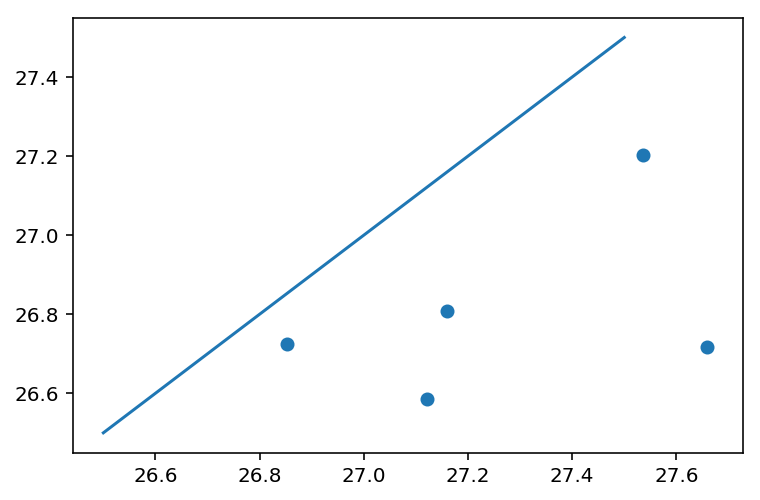

In [61]:
plt.scatter([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866], lit_m[[ 0,  1,  2,  6, 20]] )
plt.plot(np.arange(26.5,28), np.arange(26.5,28))

Text(0, 0.5, 'Dec')

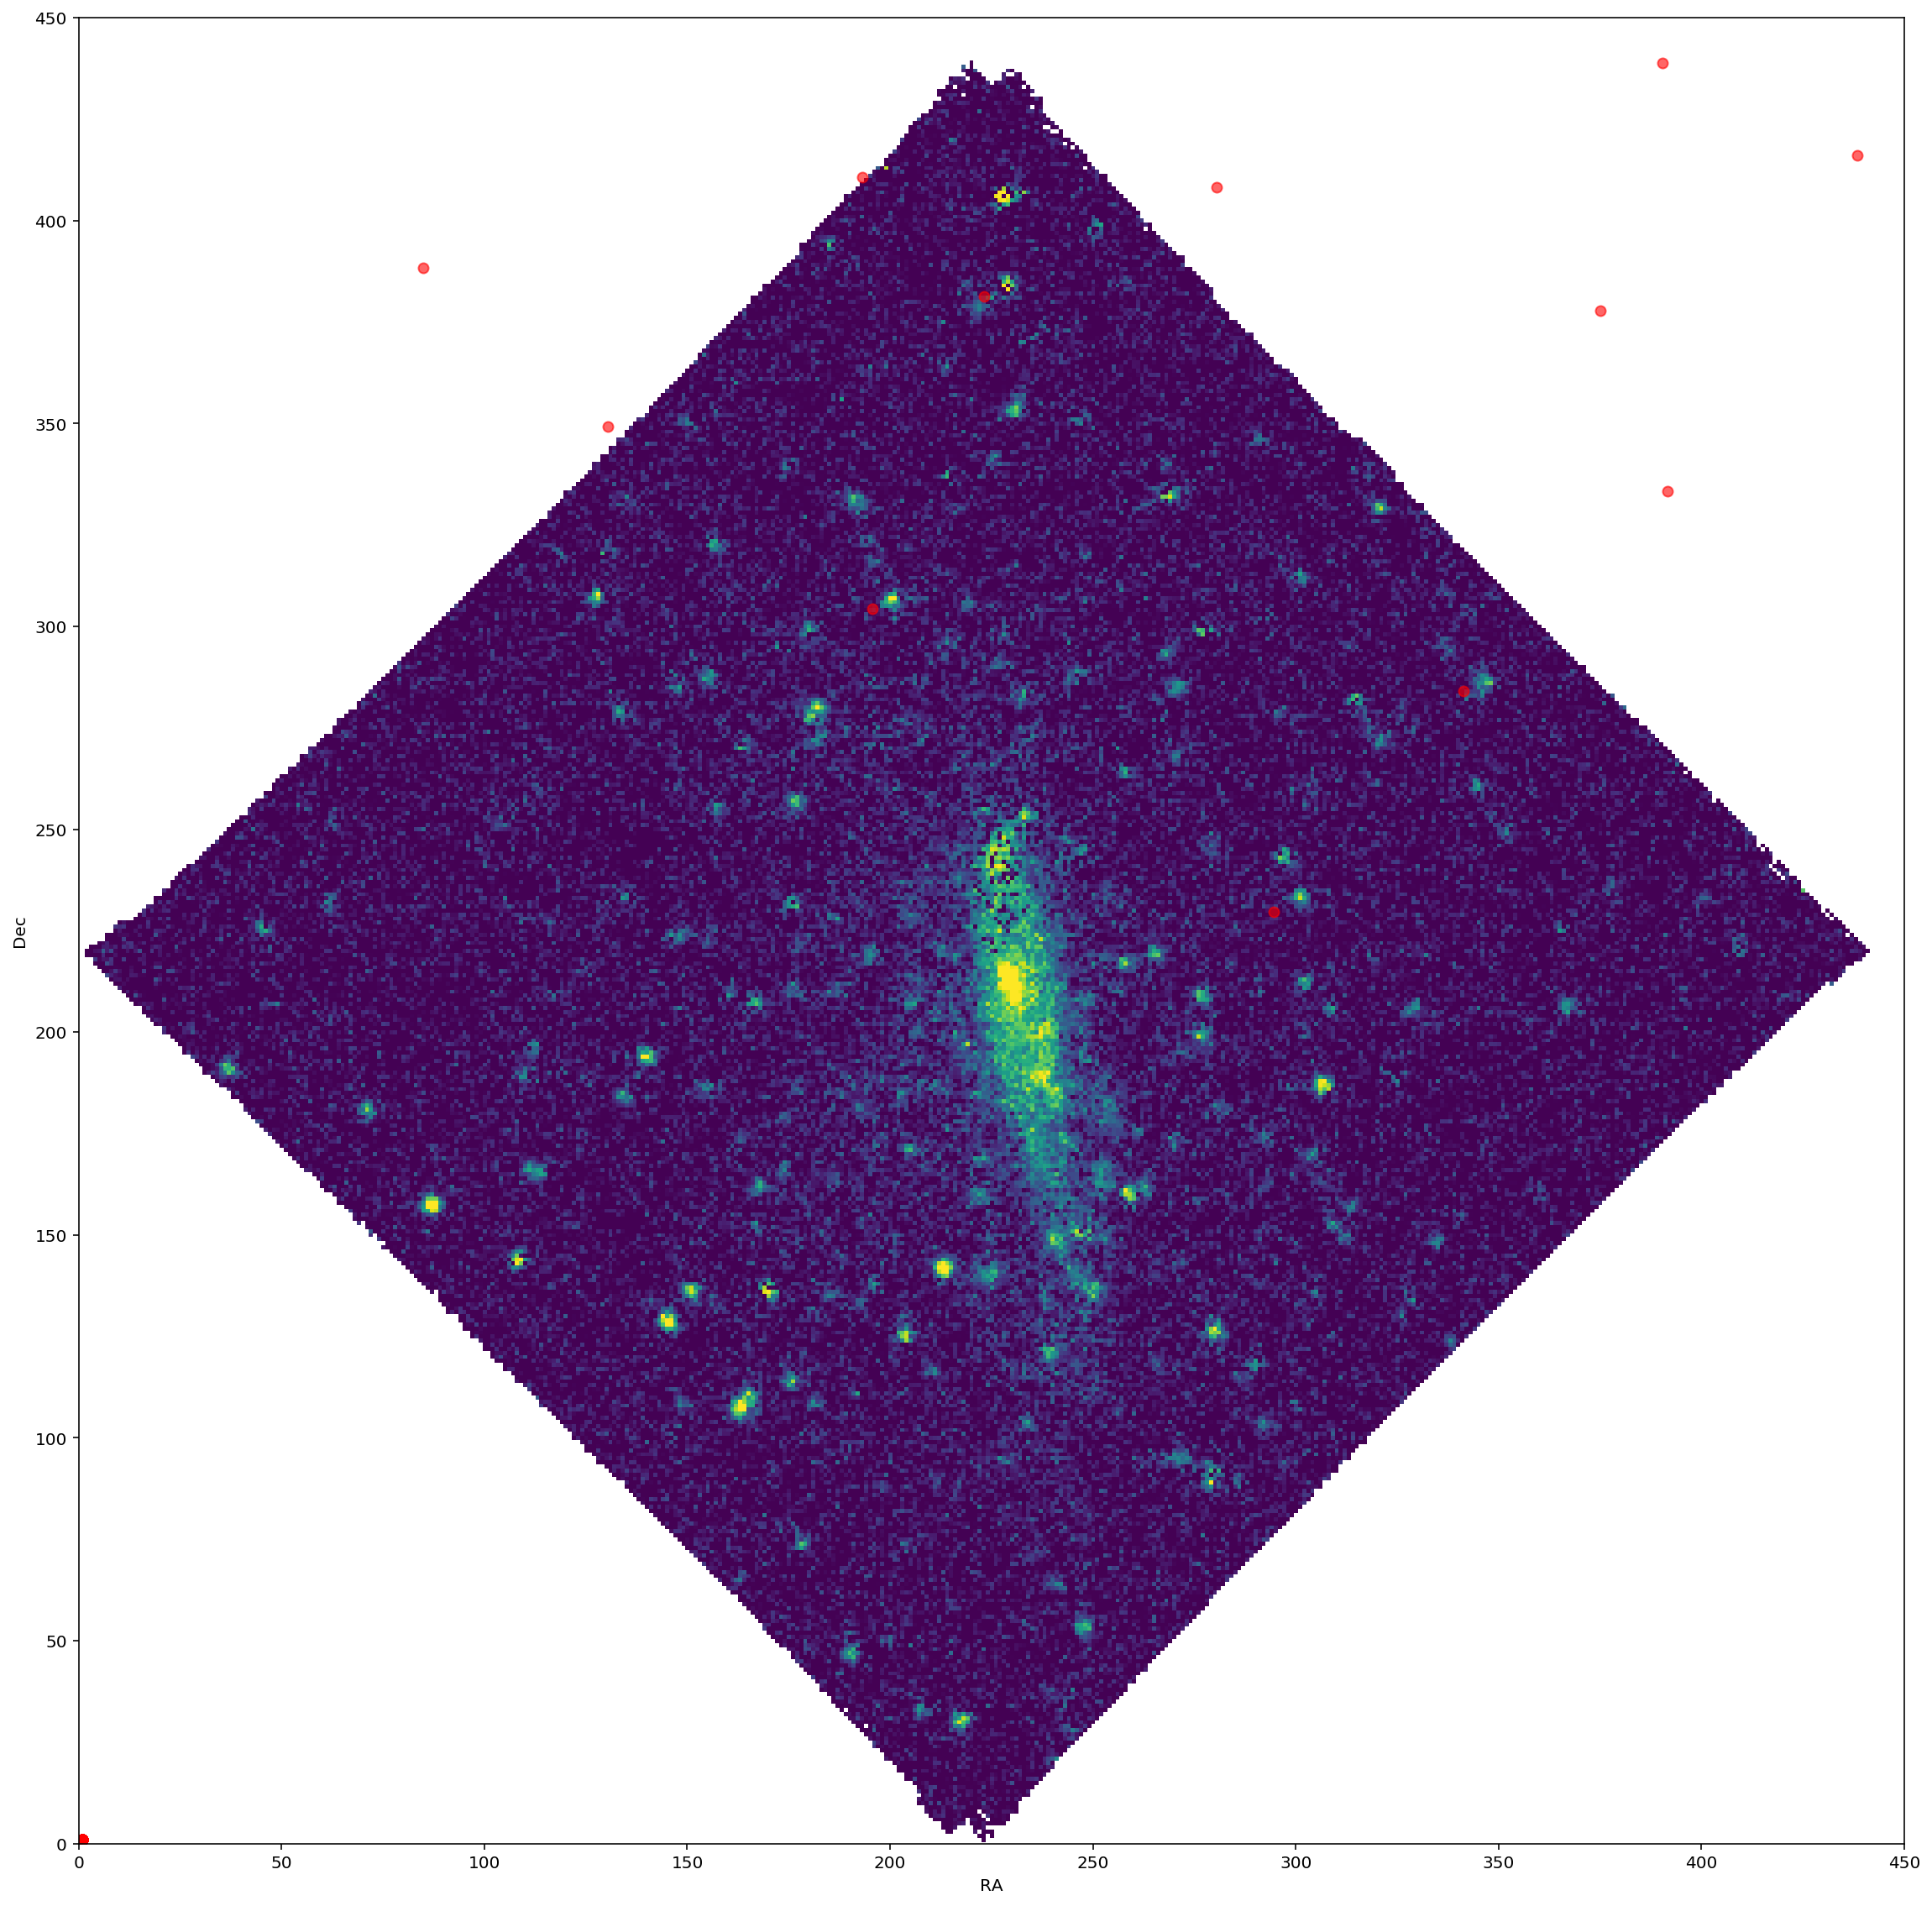

In [40]:
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,450)
plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

## FCC219

[0.00027301 0.00022469 0.00024347 0.00022385 0.00019106 0.00024302]
(array([ 2,  4,  7, 31, 38, 43]),)
[ 61  65 104 115 106 108]


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
61           61  03h38m49.0891s  -35d35m23.1532s -345.749869  27.594658   
65           65  03h38m48.9907s  -35d35m22.6009s  259.714851  28.093634   
104         104  03h38m50.0742s  -35d35m05.5478s -355.745398  27.353643   
115         115  03h38m52.1549s  -35d34m51.6173s -451.130710  27.669189   
106         106  03h38m53.8059s  -35d35m02.6063s -259.321397  28.158646   
108         108  03h38m49.5297s  -35d35m02.8763s   19.354254  27.316820   

       M 5007   [OIII] Flux M 5007 error       A/rN rad D    redchi Filter  \
61  -3.613009  2.925075e-17          NaN   7.341989   NaN  1.004045      Y   
65  -3.114033  1.847339e-17          NaN   4.815129   NaN  1.016195      Y   
104 -3.854023  3.652100e-17          NaN   9.963678   NaN  1.000426      Y   
115 -3.538478  2.731017e-17          NaN   7.054721   NaN  1.005559      Y   
106 -3.049021  1.739970e-17          NaN   4.337599   NaN  1.173099      Y   
108 -3.890847  3.778087e-17          NaN  10.563127   NaN  0.990047      Y   

             Chi2    [OIII]/Hb    Flux error  m 5007 error  \
61   15208.266245    25.372080           NaN           NaN   
65   15392.299328  9228.714999  8.123179e-19      0.047790   
104  15153.451480    32.677308           NaN           NaN   
115  15231.197990    23.703255           NaN           NaN   
106  17768.931222    15.369281           NaN           NaN   
108  14996.239947     1.216463  1.039995e-18      0.029875   

     F[OIII] err percent  
61                   NaN  
65              4.397234  
104                  NaN  
115                  NaN  
106                  NaN  
108             2.752703

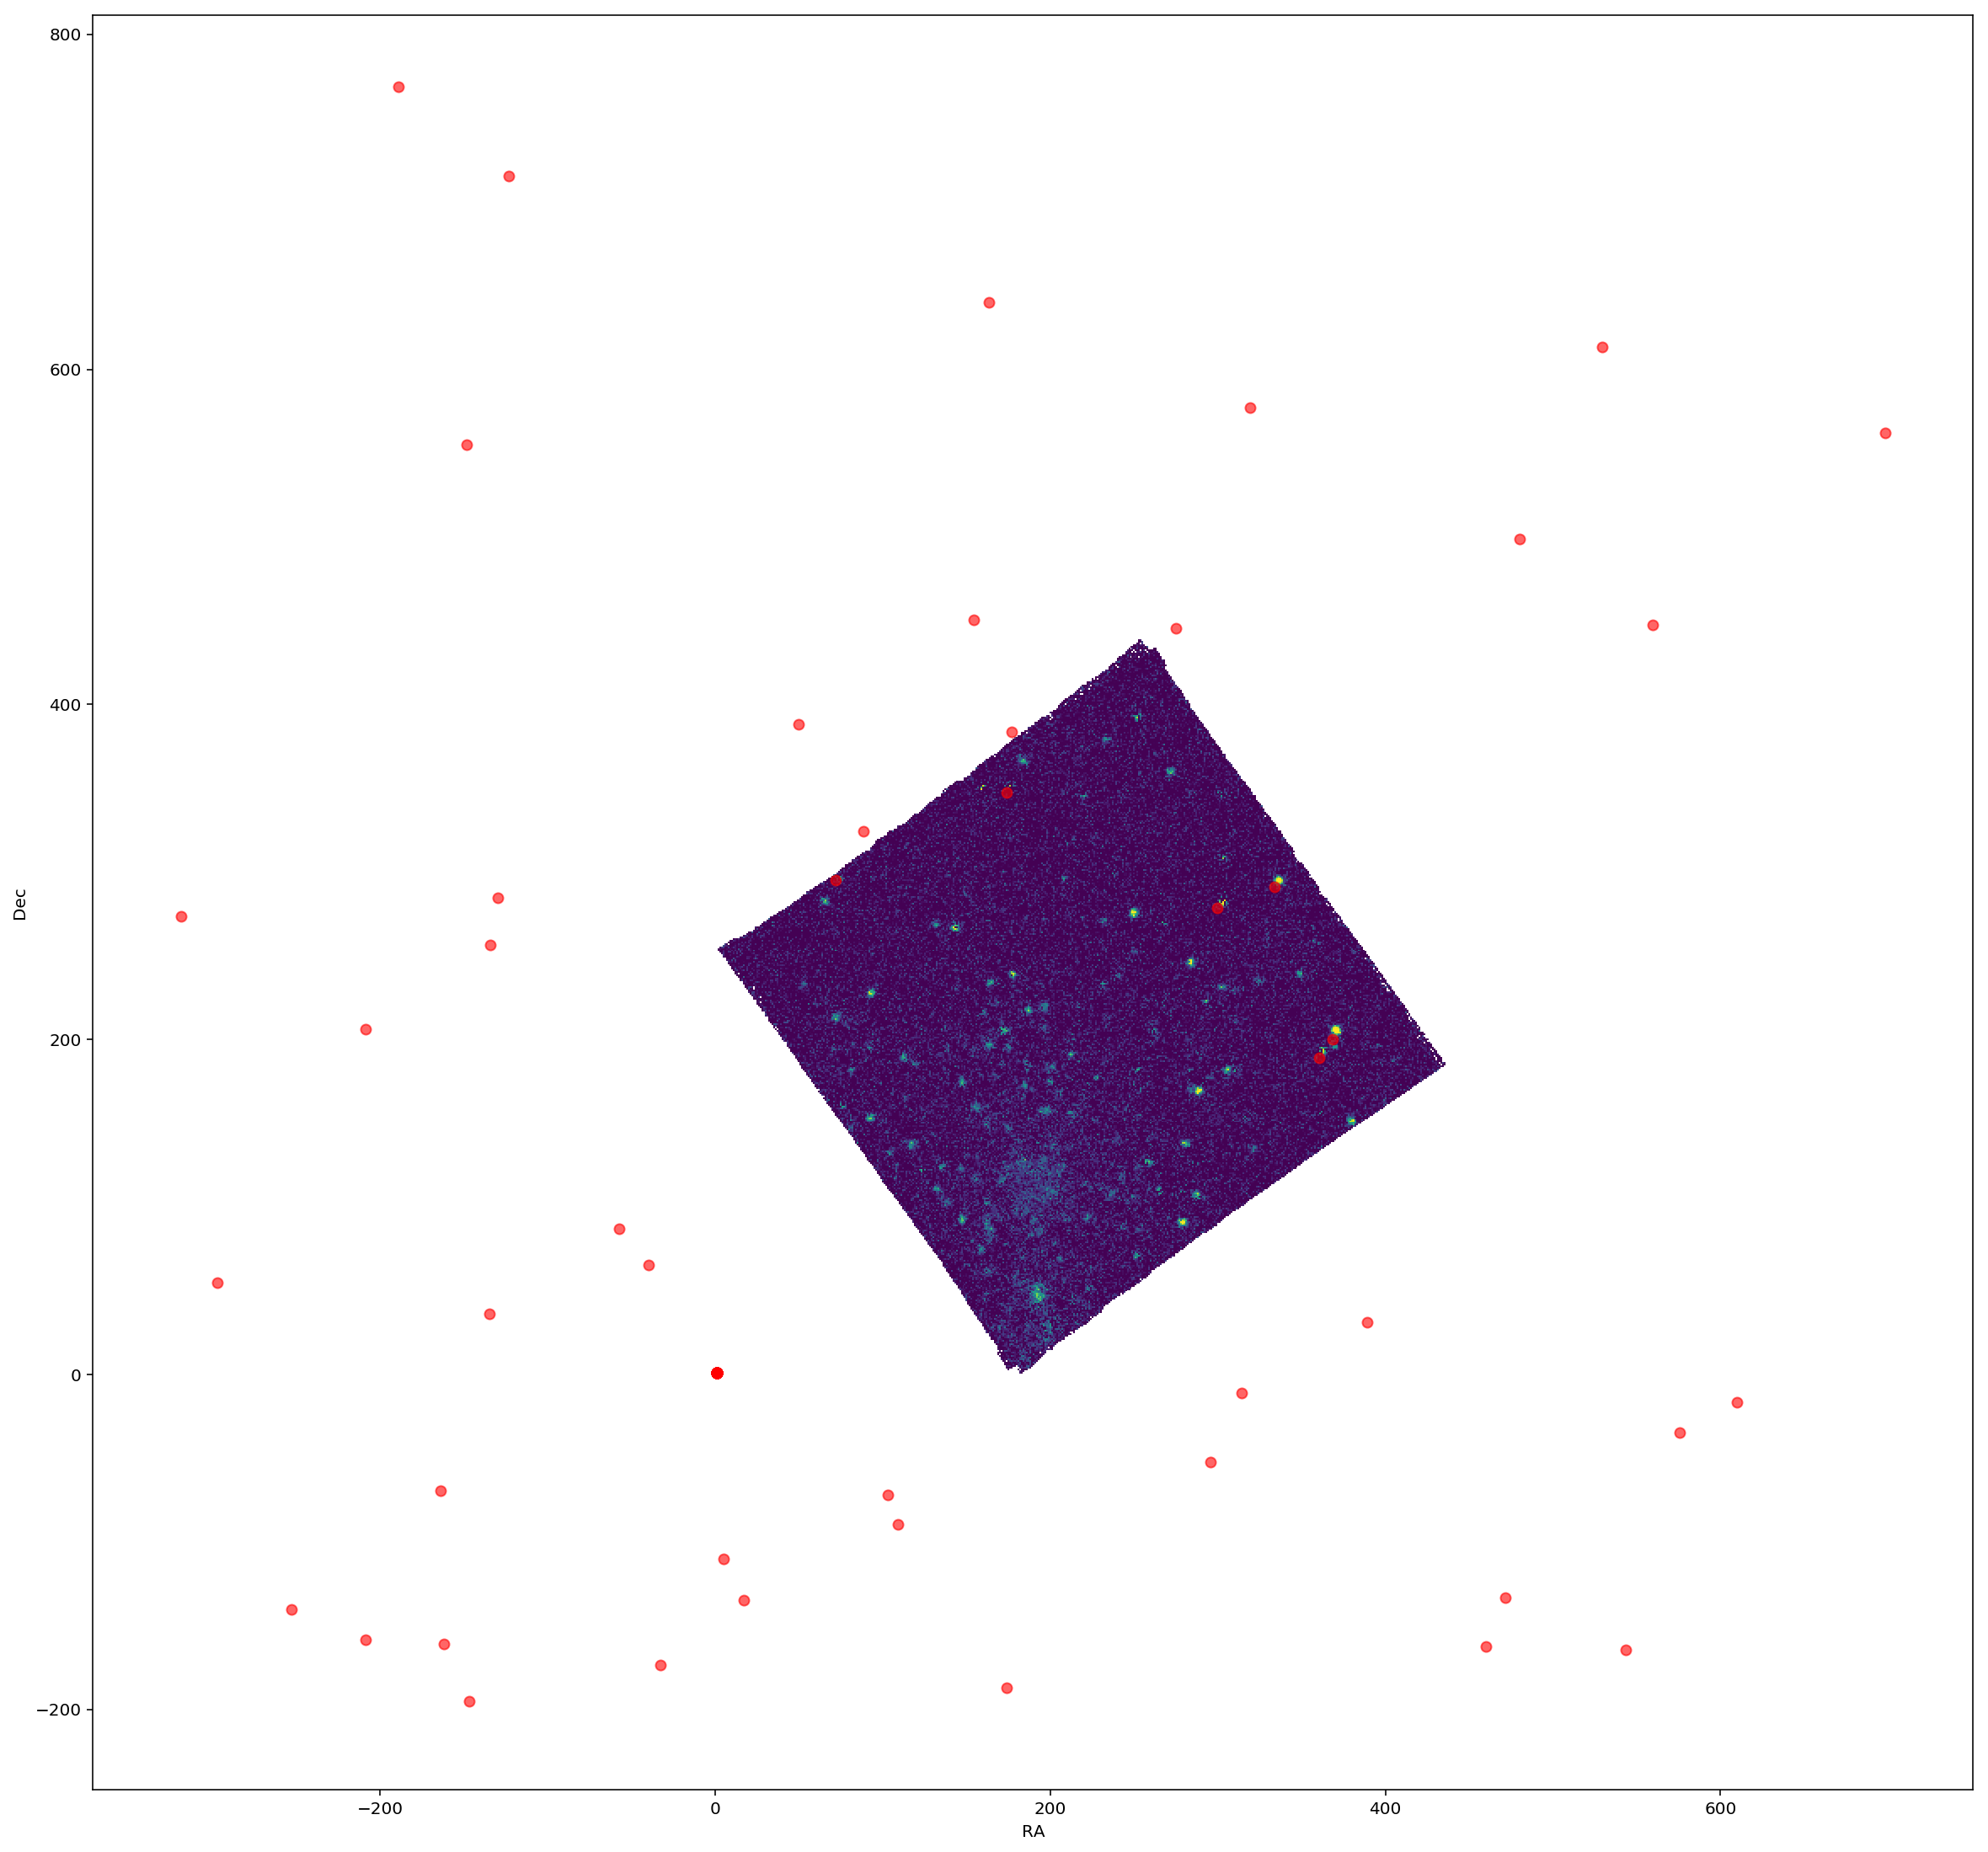

In [62]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = [list_1404[i][4] for i in np.arange(0,len(list_1404))]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
#plt.xlim(0,500)
#plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')


smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[np.where(diff<0.001)])
PNe_df.iloc[indx[np.where(diff<0.001)]]

Text(0.5, 0, '$m_{5007} $ values MUSE')

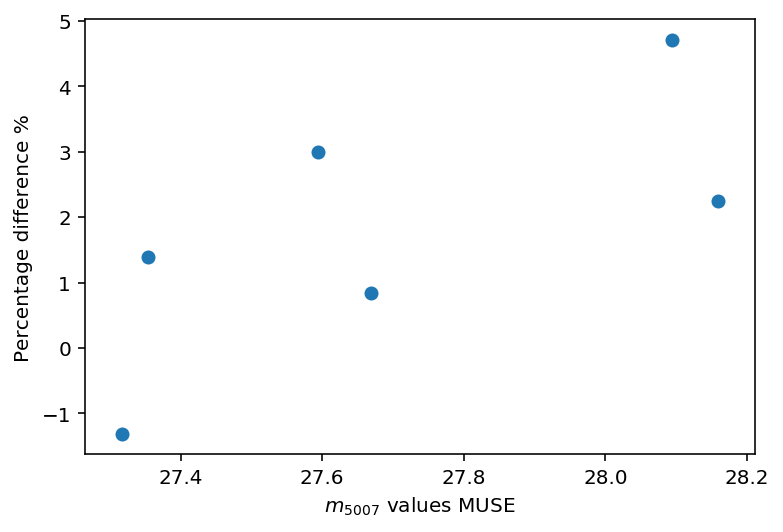

In [70]:
x_dat = PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values
y_dat = np.array(m5007_1404)[np.where(diff<0.001)]

y_d = 100*((x_dat - y_dat)/y_dat)
x_d = 100*((y_dat-x_dat)/x_dat)

plt.scatter(x_dat, y_d)
plt.ylabel("Percentage difference %")
plt.xlabel("$m_{5007} $ values MUSE")

## Completeness testing

In [ ]:
x_data_cen, y_data_cen, map_cen, aux = open_data(gal_name)

image, wave = reconstructed_image(gal_name)
image = image.reshape([y_data_cen,x_data_cen])

mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(gal_name, mag, PNe_multi_params, Dist_est, image, peak=3.,
                                      gal_mask_params=gal_mask, star_mask_params=star_mask, 
                                      mask=True, c1=0.307 ) # Estimating the completeness for the central pointing
#PNLF_plus, PNLF_corr_plus, Abs_M_plus = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
#PNLF_min, PNLF_corr_min, Abs_M_min = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing

# Getting the normalisation
total_norm = np.sum(np.abs(PNLF_corr))*abs(Abs_M[1]-Abs_M[0])
#total_norm_plus = np.sum(PNLF_corr_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#total_norm_min = np.sum(PNLF_corr_min)*abs(Abs_M_min[1]-Abs_M_min[0])

# Scaling factor
scal = len(mag)/total_norm
#scal_plus = len(mag)/total_norm_plus
#scal_min = len(mag)/total_norm_min

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= -2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
#tot_N_PNe_plus = np.sum(PNLF_corr_plus[idx]*scal_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#tot_N_PNe_min = np.sum(PNLF_corr_min[idx]*scal_min)*abs(Abs_M_min[1]-Abs_M_min[0])

plt.figure(figsize=(18,16))

binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue', label="Completeness corrected PNLF")

plt.xlabel('$M_{5007}$', fontsize=30)
plt.ylabel('N PNe', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,25);
plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=24)
#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_PNLF.pdf", bbox_inches='tight')

In [ ]:
step = Abs_M[1]-Abs_M[0]
N_PNe = np.sum(PNLF[:25]*scal)*step
print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)

In [ ]:
galaxy_df = pd.DataFrame(columns=("Galaxy", "PNe N", "PNLF N", "N err", "Lbol", "alpha2.5",
                                  "FUV", "FUV err", "NUV", "NUV err", "Vmag", "Vmag err", 
                                  "Rmag", "Rmag err", "Bmag", "Bmag err", "B-V", "sigma", "M/H", "Mg/Fe"))

F3D_galaxies = ["FCC083", "FCC147","FCC161", "FCC167","FCC193", "FCC219", "FCC249", "FCC277", "FCC310" ]

galaxy_df["Galaxy"] = F3D_galaxies

# FCC167
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "PNe N"]  = 113
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "PNLF N"] = 335.5
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC167", "Lbol"]   = 13099002325.556799

# FCC219
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "PNe N"]  = 72
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "PNLF N"] = 166.8
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC219", "Lbol"]   = 10853399663.815323

# FCC161
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "PNe N"]  = 111
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "PNLF N"] = 188.93
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC161", "Lbol"]   = 7752216990.696291

# FCC147
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "PNe N"]  = 64
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "PNLF N"] = 112.35
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC147", "Lbol"]   = 4959958598.278064

# FCC193
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "PNe N"]  =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "PNLF N"] =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "Lbol"]   =

# FCC083
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "PNe N"]  =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "PNLF N"] =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC083", "Lbol"]   =

# FCC249
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "PNe N"]  = 13
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "PNLF N"] = 
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Lbol"]   =

# FCC310
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "PNe N"]  =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "PNLF N"] =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC310", "Lbol"]   =

# FCC277
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "PNe N"]  =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "PNLF N"] =
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "Lbol"]   =

# FCC255
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "PNe N"]  = 
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "PNLF N"] = 71.15
galaxy_df.loc[galaxy_df["Galaxy"]=="FCC255", "Lbol"]   = 1.0


galaxy_df["N err"]  = (1/np.sqrt(galaxy_df["PNe N"].values))*galaxy_df["PNLF N"]
galaxy_df["alpha2.5"] = np.log10(galaxy_df["PNLF N"].values/galaxy_df["Lbol"].values)
galax_df["sigma"]  = np.array([143,  154,  96,    131,  95,    103,   104,   80,    48])
galaxy_df["M/H"]   = np.array([0.09, 0.14, -0.13, 0.04, -0.09, -0.20, -0.26, -0.34, -0.30])
galaxy_df["Mg/Fe"] = np.array([0.20, 0.18, 0.2,   0.23, 0.13,  0.26,  0.24,  0.11,  0.14])


In [ ]:
FCC167 - Number of PNe from PNLF:  335.5 +/- 31.56
FCC219 - Number of PNe from PNLF:  166.8 +/- 19.66
FCC161 - Number of PNe from PNLF:  188.93 +/- 17.93
FCC147 - Number of PNe from PNLF:  112.35 +/- 14.04
FCC193 - Number of PNe from PNLF:  190.3 +/- 13.8
FCC083 - Number of PNe from PNLF:  139.8 +/- 11.8
FCC249 - Number of PNe from PNLF:  32.28 +/- 5.68 or mask: 43.43 +/- 6.59
FCC310 - Number of PNe from PNLF:  90.84 +/- 9.53
FCC277 - Number of PNe from PNLF:  50.92 +/- 7.14
FCC255 - Number of PNe from PNLF:  71.15 +/- 8.43


## Alpha

In [ ]:

file_name = gal_name+"_data/"+gal_name+"center.fits"

lum_g_bol = ppxf_L_tot(file=file_name, gal_mask_params=gal_mask, star_mask_params=star_mask, mask=True, 
                       redshift=z, vel=gal_vel, dist_mod=dM)



In [ ]:
lum_g_bol

In [ ]:
#### FCC167 - 13099002325.556799
#### FCC219 - 11678451763.86619  or no star = 10853399663.815323
#### FCC161 - 7752216990.696291
#### FCC147 - 4959958598.278064
#### FCC193 - 4517220015.180022
#### FCC083 - 4588451801.077266
#### FCC249 - 2262353464.011233 - no mask  3070607923.9227934
#### FCC310 - 2926851406.531234
#### FCC277 - 1709225142.8519616
#### FCC255 - 


In [18]:
N_PNe/lum_g_bol

2.5613705592863776e-08

#### FCC167 - 2.561e-8
#### FCC219 - 14.40e-9
#### FCC161 - 2.360e-8
#### FCC147 - 2.006e-8
#### FCC193 - 4.212e-8
#### FCC083 - 3.047e-8
#### FCC249 - 1.428e-8
#### FCC310 - 3.104e-8
#### FCC277 - 2.979e-8
#### FCC255

In [127]:
N_PNe = np.array([342.8, 168.1, 211.8, 112.5, 249.8, 139.8, 29.00])
N_PNe_pm = np.array([18.5, 12.9, 14.5, 10.6, 15.8, 11.8, 5.83])
L_bol = np.array([23740270563.169445, 11678451763.86619, 8973042025.01011, 5600381182.962889, 4251389233.8368816, 4588451801.077266, 3070607923.9227934])

a_2_5_list = np.log10(N_PNe / L_bol)
a_2_5_upper = np.log10((N_PNe+N_PNe_pm) / L_bol)
a_delta_upper = a_2_5_upper - a_2_5_list
a_2_5_lower = np.log10((N_PNe-N_PNe_pm) / L_bol)
a_delta_lower = a_2_5_list - a_2_5_lower


In [ ]:
Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24. 3.41]
Buzzoni_log_a  = [-6.88, -6.77, -6.94, -7.5, 7.30, 6.59, 6.43, 6.77, 6.42, -6.77, -6.7, 6.89, -7.16, -7.10, -7.22, -6.82 ]

In [57]:
# list of F3D target names
F3D_galaxies = ["FCC167", "FCC219", "FCC161", "FCC147", "FCC193", "FCC083", "FCC249", "FCC277" ]

N_PNe = np.array([342.8, 166.8, 211.8, 112.5, 190.3, 139.8, 38.13, 50.92])
N_PNe_pm = np.array([18.5, 12.9, 14.5, 10.6, 13.8, 11.8, 10.58, 7.14])
L_bol = np.array([23740270563.169445, 10853399663.815323, 8973042025.01011, 5600381182.962889, 
                  4517220015.180022, 4588451801.077266, 2581155549.593469, 1709225142.8519616])

a_2_5_list = np.log10(N_PNe / L_bol)
a_2_5_upper = np.log10((N_PNe+N_PNe_pm) / L_bol)
a_delta_upper = a_2_5_upper - a_2_5_list
a_2_5_lower = np.log10((N_PNe-N_PNe_pm) / L_bol)
a_delta_lower = a_2_5_list - a_2_5_lower

F3D_Rmag = np.array([9.27, 8.57, 10.47, 10.50, 10.69, 10.84, 12.07, 12.34])
F3D_sigma = np.array([143, 154, 96, 131, 95, 103, 104, 80])
F3D_M_H = np.array([0.09, 0.14, -0.13, 0.04, -0.09, -0.20, -0.26, -0.34])
F3D_Mg_Fe = np.array([0.20, 0.18, 0.2, 0.23, 0.13, 0.26, 0.24, 0.11])

viz_Bai_15 = Vizier(columns=["AsyFUV", "e_AsyFUV", "AsyNUV", "e_AsyNUV", "Bmag", "e_Bmag", "B-V"])

F3D_tables_15 = []

for f in galaxy_df["Galaxy"].values:
    F3D_tables_15.append(viz_Bai_15.query_object(f, catalog="J/ApJS/220/6/uvgal"))
    
F3D_FUV = np.ones(len(F3D_tables_15))
F3D_FUV_err = np.ones_like(F3D_FUV)
F3D_NUV = np.ones_like(F3D_FUV)
F3D_NUV_err = np.ones_like(F3D_FUV)
F3D_Bmag = np.ones_like(F3D_FUV)
F3D_Vmag_err = np.ones_like(F3D_FUV)
F3D_B_m_V = np.ones_like(F3D_FUV)

for i, t in enumerate(F3D_tables_15):
    if len(t) == 0:
        continue
    else:
        F3D_FUV[i] = t[0][0]["AsyFUV"]
        F3D_FUV_err[i] = t[0][0]["e_AsyFUV"]
        F3D_NUV[i] = t[0][0]["AsyNUV"]
        F3D_NUV_err[i] = t[0][0]["e_AsyNUV"]
        F3D_Bmag[i]   = t[0][0]["Bmag"]
        F3D_Vmag_err[i] = t[0][0]["e_Bmag"]
        F3D_B_m_V[i]  = t[0][0]["B-V"]

F3D_Vmag = F3D_Bmag - F3D_B_m_V

# experimental update
# for i, t in enumerate(galaxy_df["F3D_table_15"]):
#     if len(t) == 0:
#         continue
#     else:
#         galaxy_df.loc[i, "FUV"] = t[0][0]["AsyFUV"]
#         galaxy_df.loc[i, "FUV err"] = t[0][0]["e_AsyFUV"]
#         galaxy_df.loc[i, "NUV"] = t[0][0]["AsyNUV"]
#         galaxy_df.loc[i, "NUV err"] = t[0][0]["e_AsyNUV"]
#         galaxy_df.loc[i, "Bmag"] = t[0][0]["Bmag"]
#         galaxy_df.loc[i, "Vmag err"] = t[0][0]["e_Bmag"]
#         galaxy_df.loc[i, "B-V"] = t[0][0]["B-V"]
# 
# galaxy_df["Vmag"] = galaxy_df["Bmag"] - galaxy_df["B-V"]
#
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "FUV"]     = 18.66
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "FUV err"] = 0.04
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "NUV"]     = 16.73
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC193", "NUV err"] = 0.01
#
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "FUV"]      = 19.796
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "FUV err"]  = 0.162
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "NUV"]      = 17.73
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "NUV err"]  = 0.051
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Vmag"]     = 12.59
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC249", "Vmag err"] = 0.08
#
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "FUV"]      = 20.283
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "FUV err"]  = 0.229
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "NUV"]      = 17.962
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "NUV err"]  = 0.052
# galaxy_df.loc[galaxy_df["Galaxy"]=="FCC277", "Bmag"]     = 13.77

# galaxy_df["FUV-V"]   = galaxy_df["FUV"] - galaxy_df["Vmag"]
# galaxy_df["FUV-B"]   = galaxy_df["FUV"] - galaxy_df["Bmag"]
# galaxy_df["FUV-NUV"] = galaxy_df["FUV"] - galaxy_df["NUV"]
# galaxy_df["FUV-R"]   = galaxy_df["FUV"] - galaxy_df["Rmag"]


#FCC193
F3D_FUV[F3D_galaxies.index("FCC193")] = 18.66 
F3D_FUV_err[F3D_galaxies.index("FCC193")] = 0.04
F3D_NUV[F3D_galaxies.index("FCC193")] = 16.73
F3D_NUV_err[F3D_galaxies.index("FCC193")] = 0.01
#FCC249
F3D_FUV[F3D_galaxies.index("FCC249")] = 19.796 
F3D_FUV_err[F3D_galaxies.index("FCC249")] = 0.162
F3D_NUV[F3D_galaxies.index("FCC249")] = 17.73
F3D_NUV_err[F3D_galaxies.index("FCC249")] = 0.051
F3D_Vmag[F3D_galaxies.index("FCC249")] = 12.59
F3D_Vmag_err[F3D_galaxies.index("FCC249")] = 0.08
#FCC277
F3D_FUV[F3D_galaxies.index("FCC277")]     = 20.283
F3D_FUV_err[F3D_galaxies.index("FCC277")] = 0.229
F3D_NUV[F3D_galaxies.index("FCC277")]     = 17.962
F3D_NUV_err[F3D_galaxies.index("FCC277")] = 0.052
F3D_Bmag[F3D_galaxies.index("FCC277")]    = 13.77


F3D_FUV_m_V = F3D_FUV - F3D_Vmag
F3D_FUV_m_B = F3D_FUV - F3D_Bmag
F3D_FUV_m_NUV = F3D_FUV - F3D_NUV
F3D_FUV_m_R = F3D_FUV - F3D_Rmag

#F3D_FUV[F3D_FUV<=1] = np.nan

##### Buzzoni data
list_of_B_g = ["205", "221", "224", "1316", "1344", "1399", "3031", "3115",
                 "3377", "3379", "3384", "4374", "4382", "4406", "4477", "4486",
                 "4594", "4649", "4697", "5128"]

Buzzoni_UV_m_V = [1.19,4.50, 3.51, 5.0, 2.05, 3.43, 3.86, 3.9, 3.55, 4.22, 3.72, 3.42, 2.04, 2.24, 3.41]
Buzzoni_log_a  = np.array([-6.88, -6.77, -6.94, -7.5, -6.75, -7.30, -6.8, -6.59, -6.43, -6.77, -6.42, -6.77, -6.7, -6.89, -7.16, -7.10, -6.66, -7.22, -6.82, -6.3])

Buzzoni_tables_15 = []
for g in list_of_B_g:
    Buzzoni_tables_15.append(viz_Bai_15.query_object("NGC"+g, catalog="J/ApJS/220/6/uvgal"))


B_FUV = np.ones(len(Buzzoni_tables_15))
B_FUV_err = np.ones_like(B_FUV)
B_Bmag = np.ones_like(B_FUV)
B_Vmag_err = np.ones_like(B_FUV)
B_B_m_V = np.ones_like(B_FUV)

for i, t in enumerate(Buzzoni_tables_15):
    if len(t) == 0:
        continue
    else:
        B_FUV[i]      = t[0][0]["AsyFUV"]
        B_FUV_err[i]  = t[0][0]["e_AsyFUV"]
        B_Bmag[i]     = t[0][0]["Bmag"]
        B_Vmag_err[i] = t[0][0]["e_Bmag"]
        B_B_m_V[i]    = t[0][0]["B-V"]

B_Vmag = B_Bmag - B_B_m_V

FUV_index_check = np.concatenate((np.where(B_FUV==1)[0], np.where(np.isnan(B_FUV))[0])) # get the indexes of 1's and nans
V_index_check = np.concatenate((np.where(B_Vmag==0)[0], np.where(np.isnan(B_Vmag))[0]))

# Corrections
B_FUV[1] = 15.84
B_FUV_err[1] = 0.03
B_Vmag[1] = 8.08
B_Vmag_err[1] = 0.05

B_FUV[4] = 17.841
B_FUV_err[4] = 0.053
B_Vmag[4] = 10.75
B_Vmag_err[4] = 0.02

B_FUV[8] = 16.30
B_FUV_err[8] = 0.05

B_FUV[12] = 15.18
B_FUV_err[12] = 0.01
B_Vmag[12] = 9.38
B_Vmag_err[12] = 0.08

B_FUV[17] = 15.15
B_FUV_err[17] = 0.01
B_Vmag[17] = 9.83
B_Vmag_err[17] = 0.08

B_FUV[18] = 16.57
B_FUV_err[18] = 0.02
B_Vmag[18] = 10.00
B_Vmag_err[18] = 0.02


B_FUV_m_V = B_FUV - B_Vmag
B_FUV_m_B = B_FUV - B_Bmag

/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Warning: converting a masked element to nan.
/local/tspriggs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Warning: converting a masked element to nan.


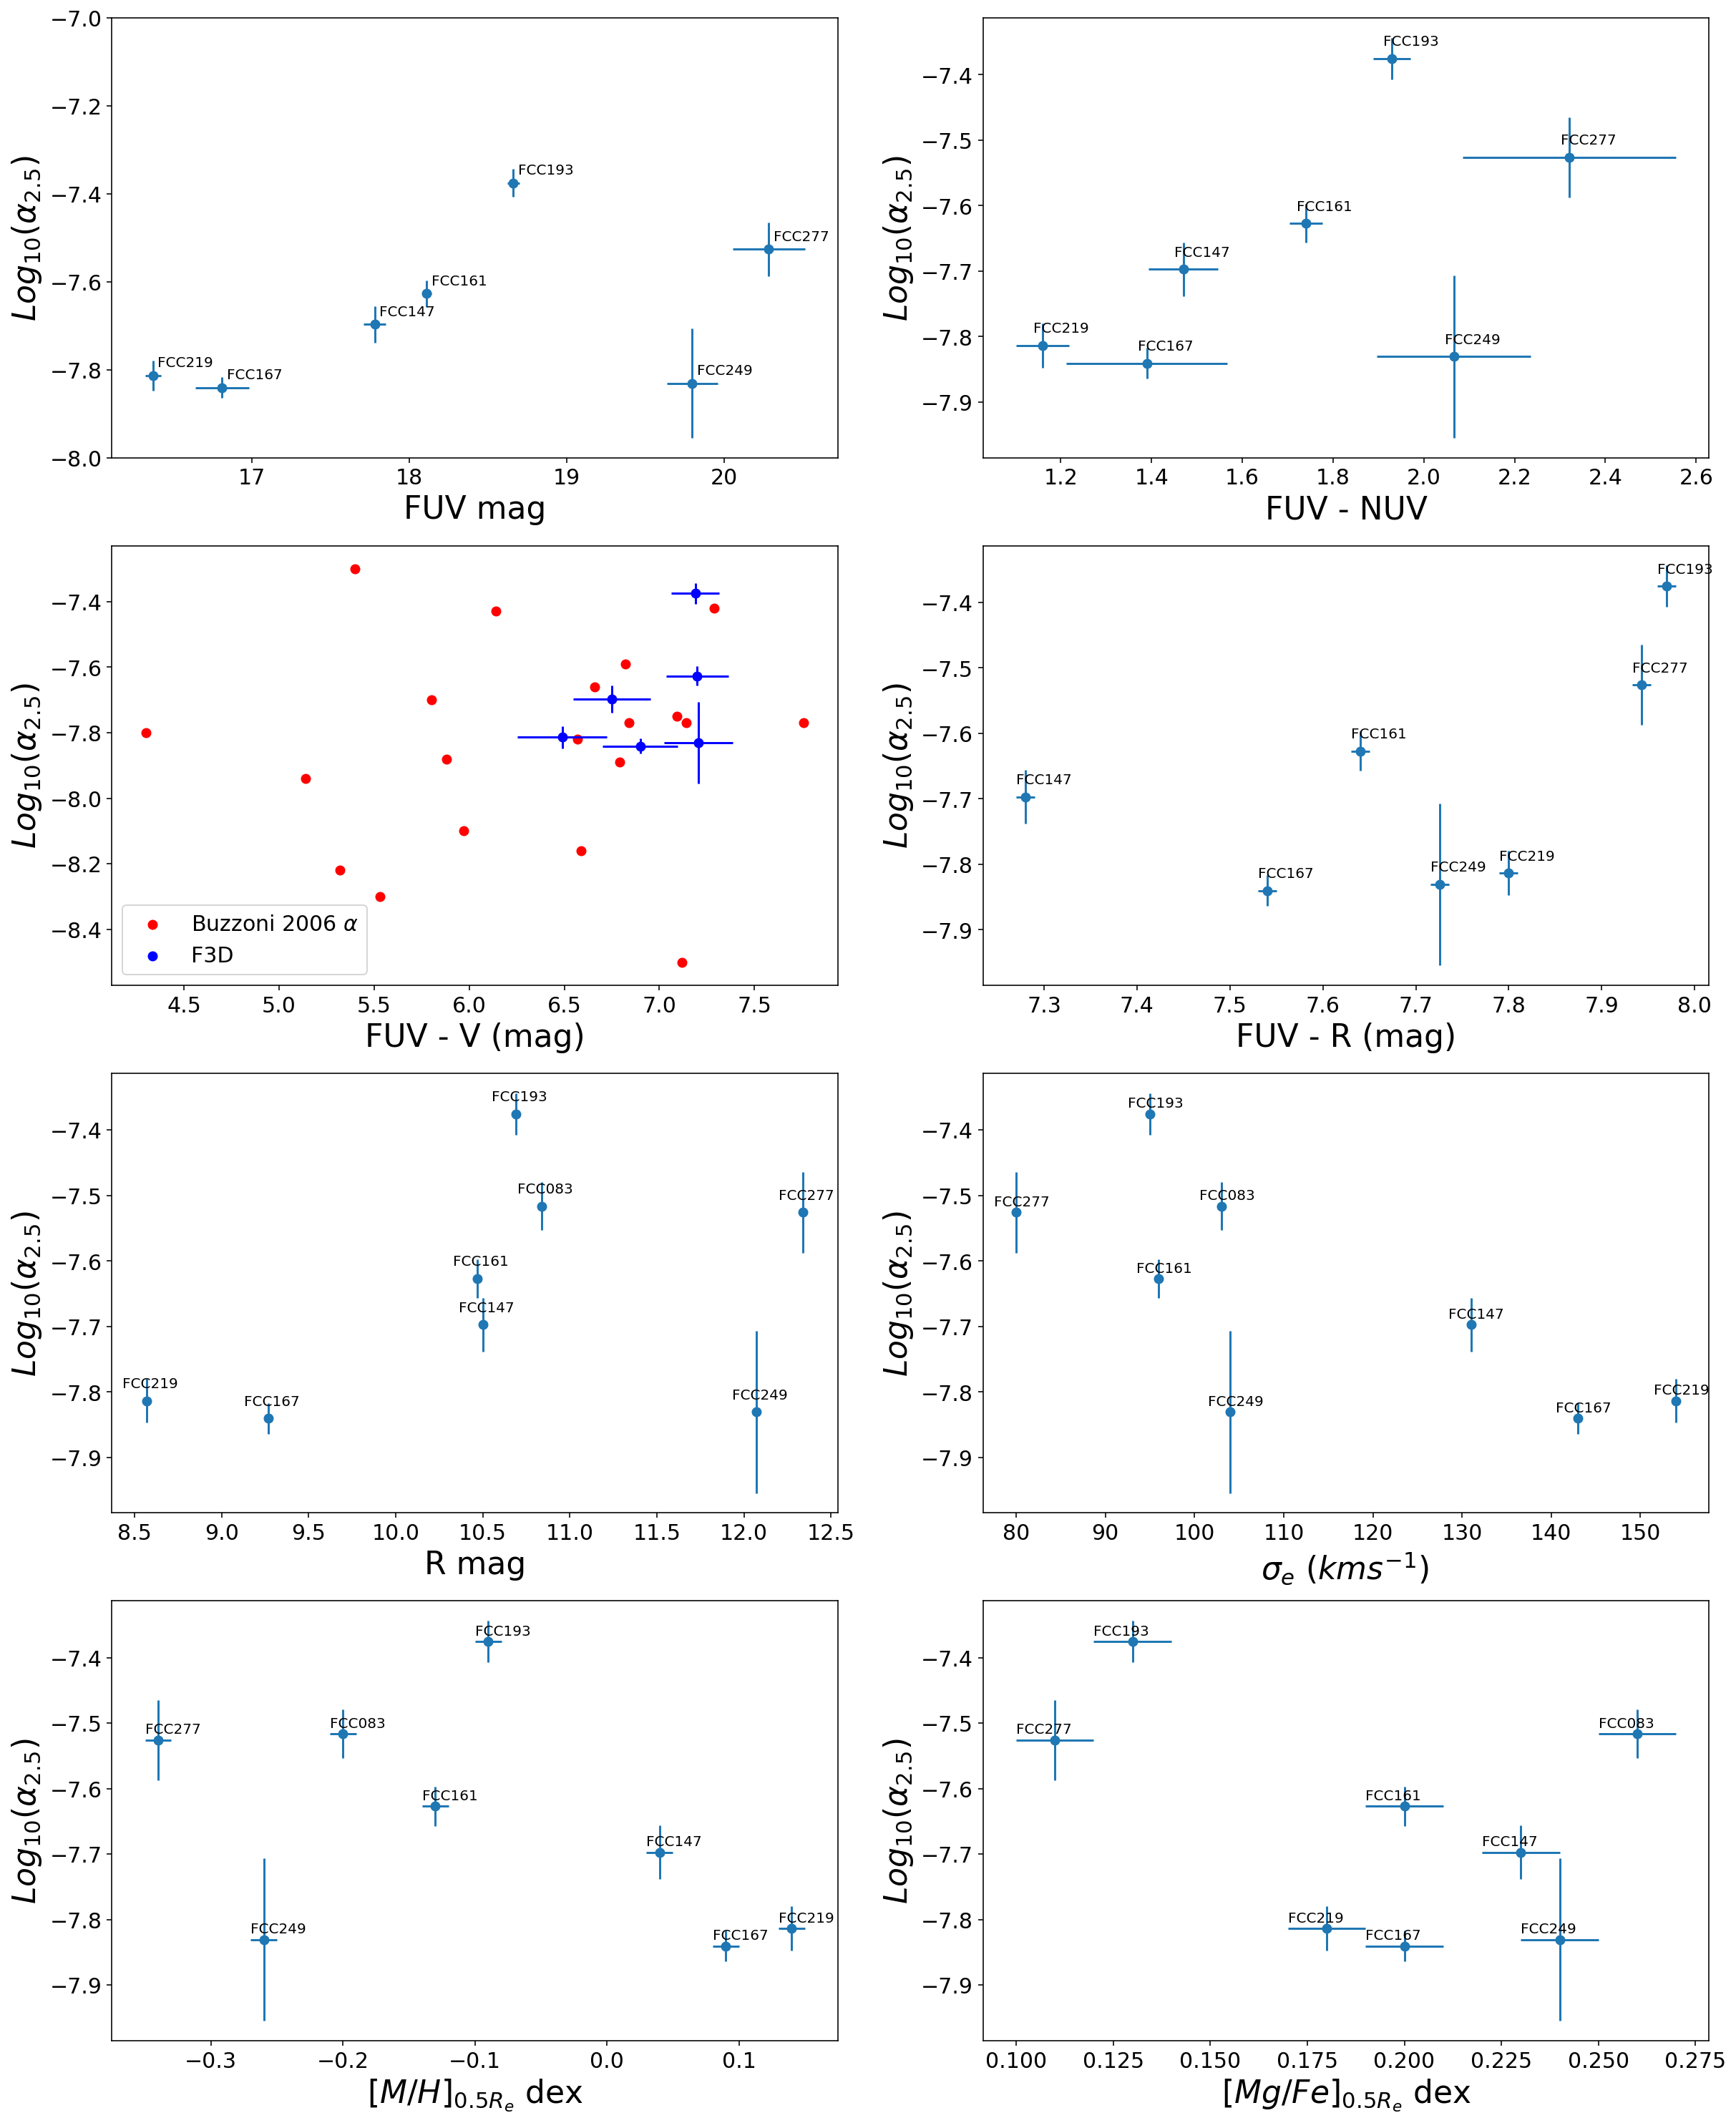

In [62]:
f_size = 22
l_size = 15

plt.figure(figsize=(20,26))

ax1 = plt.subplot(4,2,1) # FUV
plt.scatter(F3D_FUV, a_2_5_list)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("FUV mag", fontsize=f_size)
plt.errorbar(F3D_FUV, a_2_5_list, xerr=F3D_FUV_err, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.tick_params(labelsize=l_size)
ax1.set_ylim(-8,-7)
#ax1 = plt.gca()
for i, name in enumerate(F3D_galaxies):
    ax1.annotate(name, (F3D_FUV[i]+0.03, a_2_5_list[i]+0.02), color="black", size=10)


ax2 = plt.subplot(4,2,2) # FUV - NUV
plt.scatter(F3D_FUV_m_NUV, a_2_5_list)
plt.errorbar(F3D_FUV_m_NUV, a_2_5_list, xerr=np.sqrt(F3D_NUV_err**2+F3D_FUV_err**2), yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(F3D_galaxies):
    ax2.annotate(name, (F3D_FUV_m_NUV[i]-0.02, a_2_5_list[i]+0.02), color="black", size=10)


ax3 = plt.subplot(4,2,3) # FUV - V
plt.scatter(B_FUV_m_V, Buzzoni_log_a-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.scatter(F3D_FUV_m_V, a_2_5_list, c="b", label="F3D")
plt.errorbar(F3D_FUV_m_V, a_2_5_list, xerr=np.sqrt(F3D_Vmag_err**2+F3D_FUV_err**2), yerr= np.median((a_delta_upper, a_delta_lower), 0), c="b", ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - V (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.legend(fontsize=l_size)
#plt.xlim(4,)
ax3.tick_params(labelsize=l_size)



ax4 = plt.subplot(4,2,4) # FUV - R
plt.scatter(F3D_FUV_m_R, a_2_5_list)
plt.errorbar(F3D_FUV_m_R, a_2_5_list, xerr=0.01, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.xlabel("FUV - R (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(F3D_galaxies):
    ax4.annotate(name, (F3D_FUV_m_R[i]-0.01, a_2_5_list[i]+0.02), color="black", size=10)
    
ax5 = plt.subplot(4,2,5)
plt.scatter(F3D_Rmag, a_2_5_list)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("R mag", fontsize=f_size)
plt.errorbar(F3D_Rmag, a_2_5_list, xerr=0.01, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")

plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(F3D_galaxies):
    ax5.annotate(name, (F3D_Rmag[i]-0.14, a_2_5_list[i]+0.02), color="black", size=10)
    
ax6 = plt.subplot(4,2,6)
plt.scatter(F3D_sigma, a_2_5_list)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$\sigma_{e} \ (km s^{-1})$ ", fontsize=f_size)
plt.errorbar(F3D_sigma, a_2_5_list, xerr=9.0, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.tick_params(labelsize=l_size)
for i, name in enumerate(F3D_galaxies):
    ax6.annotate(name, (F3D_sigma[i]-2.5, a_2_5_list[i]+0.01), color="black", size=10)
    
    
ax7 = plt.subplot(4,2,7) # M/H metallicity
plt.scatter(F3D_M_H, a_2_5_list)
plt.errorbar(F3D_M_H, a_2_5_list, xerr=0.035, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(F3D_galaxies):
    ax7.annotate(name, (F3D_M_H[i]-0.01, a_2_5_list[i]+0.01), color="black", size=10)
    
ax8 = plt.subplot(4,2,8)
plt.scatter(F3D_Mg_Fe, a_2_5_list)
plt.errorbar(F3D_Mg_Fe, a_2_5_list, xerr=0.15, yerr= np.median((a_delta_upper, a_delta_lower), 0), ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(F3D_galaxies):
    ax8.annotate(name, (F3D_Mg_Fe[i]-0.01, a_2_5_list[i]+0.01), color="black", size=10)
    
#plt.savefig("Plots/alpha_comparison_plots.pdf")


In [57]:
stats.spearmanr(np.concatenate((B_FUV_m_V,F3D_FUV_m_V)), np.concatenate((np.array(Buzzoni_log_a-1),a_2_5_log)), axis=0, nan_policy="omit")

SpearmanrResult(correlation=0.32535074328234265, pvalue=0.10483411954334809)